# Setup

In [1]:
import torch

if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  running_on_colab = True
else:
  print('Not running on Colab')
  running_on_colab = False

if running_on_colab:
    print(torch.__version__)
    !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install -q git+https://github.com/snap-stanford/deepsnap.git
    !pip install pyarrow
    !pip install fastparquet

    from google.colab import drive
    drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/GCNN/'
    data_folder = filepath+"graph_data/"
    experiments_folder = filepath+"experiments/merged_types_experiments/"

    import sys
    sys.path.append(filepath + "run_in_colab")

else:
    data_folder = "../../../data/processed/graph_data_nohubs/merged_types/"
    experiments_folder = "../../../data/experiments/design_space_merged_experiment/fixed_bug_exp/"

Not running on Colab


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import plotly.express as px

import sys
sys.path.append("../../..")
from src.models import training_utils, base_model

# Load data

In [3]:
results_aggrs = pd.read_parquet(experiments_folder+"experiment_27_09_23__19_14_53.parquet")
results_layers = pd.read_parquet(experiments_folder+"experiment_27_09_23__19_47_32.parquet")
filter_columns = ['post_process_layers','pre_process_layers', 'normalize_output', 'msg_passing_layers', 'micro_aggregation', 'macro_aggregation', 'L2_norm',
                  'hidden_channels', 'feature_type', 'feature_dim', 'conv_type', 'layer_connectivity', 'jumping_knowledge','auc','experiment_name']
df = pd.concat([results_aggrs,results_layers])
results = df[filter_columns]
# node_data = load_node_csv(data_folder+"nohub_graph_nodes.csv","node_index","node_type")
# train_data, val_data = load_data(data_folder+"split_dataset/")

In [16]:
df.sort_values(by="auc",ascending=False)[:5].reset_index(drop=True)[["conv_type","feature_type","micro_aggregation","macro_aggregation","pre_process_layers","post_process_layers","auc"]]

conv_type feature_type micro_aggregation macro_aggregation  \
0  SAGEConv         ones               sum               sum   
1  SAGEConv         ones               sum              mean   
2  SAGEConv       random               sum              mean   
3  SAGEConv       random               sum               sum   
4  SAGEConv         ones               sum               max   

   pre_process_layers  post_process_layers    auc  
0                   0                    1  0.969  
1                   0                    1  0.969  
2                   0                    1  0.964  
3                   0                    1  0.964  
4                   0                    1  0.962

In [71]:
print(df.sort_values(by="auc",ascending=False)[:5].reset_index(drop=True)[["conv_type","feature_type","micro_aggregation","macro_aggregation","pre_process_layers","post_process_layers","auc"]].style.to_latex())

\begin{tabular}{lllllrrr}
 & conv_type & feature_type & micro_aggregation & macro_aggregation & pre_process_layers & post_process_layers & auc \\
0 & SAGEConv & ones & sum & sum & 0 & 1 & 0.969000 \\
1 & SAGEConv & ones & sum & mean & 0 & 1 & 0.969000 \\
2 & SAGEConv & random & sum & mean & 0 & 1 & 0.964000 \\
3 & SAGEConv & random & sum & sum & 0 & 1 & 0.964000 \\
4 & SAGEConv & ones & sum & max & 0 & 1 & 0.962000 \\
\end{tabular}



In [25]:
df.sort_values(by="auc",ascending=False).reset_index().tail(5)[["conv_type","feature_type","micro_aggregation","macro_aggregation","pre_process_layers","post_process_layers","auc","heads"]]

conv_type feature_type micro_aggregation macro_aggregation  \
67   GATConv       random              mean               max   
68   GATConv         ones              mean               max   
69  SAGEConv         ones              mean              mean   
70  SAGEConv         ones              mean              mean   
71  SAGEConv         ones              mean              mean   

    pre_process_layers  post_process_layers    auc  heads  
67                   0                    1  0.801      2  
68                   0                    1  0.792      2  
69                   1                    0  0.768      1  
70                   2                    2  0.744      1  
71                   1                    2  0.507      1

In [85]:
{x.replace("_"," ").capitalize() for x in df.columns}

{'Auc',
 'Batch norm',
 'Conv type',
 'Curve data',
 'Delta',
 'Dropout',
 'Epochs',
 'Experiment name',
 'Feature dim',
 'Feature type',
 'Heads',
 'Hidden channels',
 'Jumping knowledge',
 'L2 norm',
 'Layer connectivity',
 'Lr',
 'Macro aggregation',
 'Micro aggregation',
 'Msg passing layers',
 'Normalize output',
 'Patience',
 'Post process layers',
 'Pre process layers',
 'Supervision types',
 'Weight decay'}

In [93]:
print(df[["conv_type","feature_type","micro_aggregation","macro_aggregation","pre_process_layers","post_process_layers","auc","heads"]].rename(columns={x:x.replace("_"," ").capitalize().replace("layers","").replace("aggregation","agg").replace("type","") for x in df.columns}).sort_values(by="Auc",ascending=False).tail(5).style.hide_index().to_latex())

\begin{tabular}{llllrrrr}
Conv  & Feature  & Micro agg & Macro agg & Pre process  & Post process  & Auc & Heads \\
GATConv & random & mean & max & 0 & 1 & 0.801000 & 2 \\
GATConv & ones & mean & max & 0 & 1 & 0.792000 & 2 \\
SAGEConv & ones & mean & mean & 1 & 0 & 0.768000 & 1 \\
SAGEConv & ones & mean & mean & 2 & 2 & 0.744000 & 1 \\
SAGEConv & ones & mean & mean & 1 & 2 & 0.507000 & 1 \\
\end{tabular}



/tmp/ipykernel_5380/2482593824.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  print(df[["conv_type","feature_type","micro_aggregation","macro_aggregation","pre_process_layers","post_process_layers","auc","heads"]].rename(columns={x:x.replace("_"," ").capitalize().replace("layers","").replace("aggregation","agg").replace("type","") for x in df.columns}).sort_values(by="Auc",ascending=False).tail(5).style.hide_index().to_latex())


In [4]:
results.sort_values(by="auc",ascending=False)

post_process_layers  pre_process_layers  normalize_output  \
9                     1                   0             False   
12                    1                   0             False   
3                     1                   0             False   
0                     1                   0             False   
15                    1                   0             False   
..                  ...                 ...               ...   
43                    1                   0             False   
52                    1                   0             False   
1                     0                   1             False   
8                     2                   2             False   
7                     2                   1             False   

    msg_passing_layers micro_aggregation macro_aggregation  L2_norm  \
9                    2               sum               sum     True   
12                   2               sum              mean     True   
3                    2               sum              mean     True   
0                    2               sum               sum     True   
15                   2               sum               max     True   
..                 ...               ...               ...      ...   
43                   2              mean               max     True   
52                   2              mean               max     True   
1                    2              mean              mean     True   
8                    2              mean              mean     True   
7                    2              mean              mean     True   

    hidden_channels feature_type  feature_dim conv_type layer_connectivity  \
9                32         ones           10  SAGEConv               None   
12               32         ones           10  SAGEConv               None   
3                32       random           10  SAGEConv               None   
0                32       random           10  SAGEConv               None   
15               32         ones           10  SAGEConv               None   
..              ...          ...          ...       ...                ...   
43               32       random           10   GATConv               None   
52               32         ones           10   GATConv               None   
1                32         ones           16  SAGEConv               None   
8                32         ones           16  SAGEConv               None   
7                32         ones           16  SAGEConv               None   

    jumping_knowledge    auc   experiment_name  
9               False  0.969    sage_aggr_type  
12              False  0.969    sage_aggr_type  
3               False  0.964    sage_aggr_type  
0               False  0.964    sage_aggr_type  
15              False  0.962    sage_aggr_type  
..                ...    ...               ...  
43              False  0.801         GAT_heads  
52              False  0.792         GAT_heads  
1               False  0.768  pre_post_process  
8               False  0.744  pre_post_process  
7               False  0.507  pre_post_process  

[72 rows x 15 columns]

# Explore results

In [22]:
def show_results(experiment_name,df=df):
    df = df[df.experiment_name == experiment_name].sort_values(by="auc",ascending=False).round(3)
    display(df)
    for experiment in df.index.values:
        training_utils.plot_training_stats(f"Experiment {experiment}", *df.loc[experiment,"curve_data"],"auc")

In [23]:
df.experiment_name.value_counts()

sage_aggr_type      18
GAT_aggr_type       18
GAT_heads           18
pre_post_process    18
Name: experiment_name, dtype: int64

## Hidden dim

L2_norm  batch_norm conv_type  delta  dropout  epochs experiment_name  \
9      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
12     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
3      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
0      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
15     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
6      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
2      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
5      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
8      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
13     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
14     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
1      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
10     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
11     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
4      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
7      True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
17     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   
16     True        True  SAGEConv    0.1      0.1     400  sage_aggr_type   

    feature_dim feature_type  heads  ...  micro_aggregation  \
9            10         ones      1  ...                sum   
12           10         ones      1  ...                sum   
3            10       random      1  ...                sum   
0            10       random      1  ...                sum   
15           10         ones      1  ...                sum   
6            10       random      1  ...                sum   
2            10       random      1  ...                max   
5            10       random      1  ...                max   
8            10       random      1  ...                max   
13           10         ones      1  ...               mean   
14           10         ones      1  ...                max   
1            10       random      1  ...               mean   
10           10         ones      1  ...               mean   
11           10         ones      1  ...                max   
4            10       random      1  ...               mean   
7            10       random      1  ...               mean   
17           10         ones      1  ...                max   
16           10         ones      1  ...               mean   

    msg_passing_layers normalize_output  patience post_process_layers  \
9                    2            False        10                   1   
12                   2            False        10                   1   
3                    2            False        10                   1   
0                    2            False        10                   1   
15                   2            False        10                   1   
6                    2            False        10                   1   
2                    2            False        10                   1   
5                    2            False        10                   1   
8                    2            False        10                   1   
13                   2            False        10                   1   
14                   2            False        10                   1   
1                    2            False        10                   1   
10                   2            False        10                   1   
11                   2            False        10                   1   
4                    2            False        10                   1   
7                    2            False        10                   1   
17                   2            False        10                   1   
16                   2      

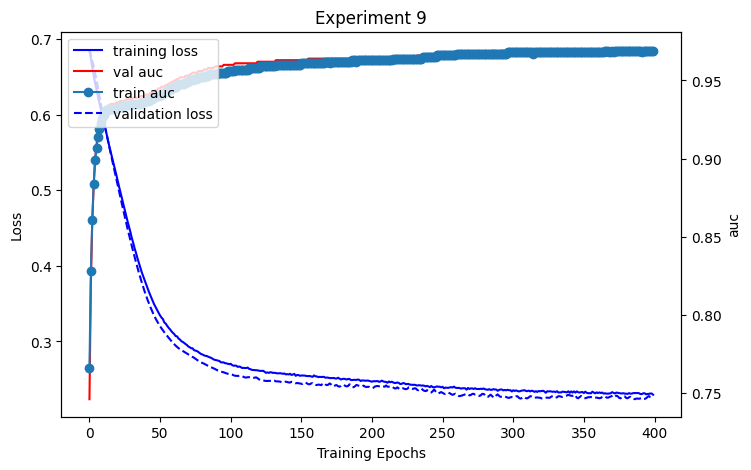

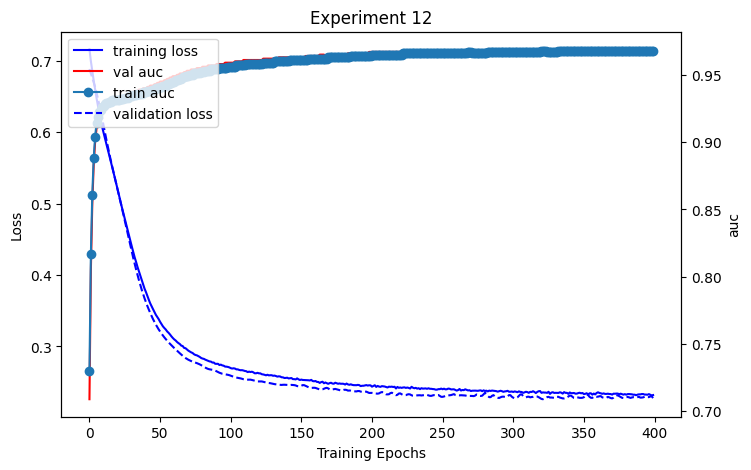

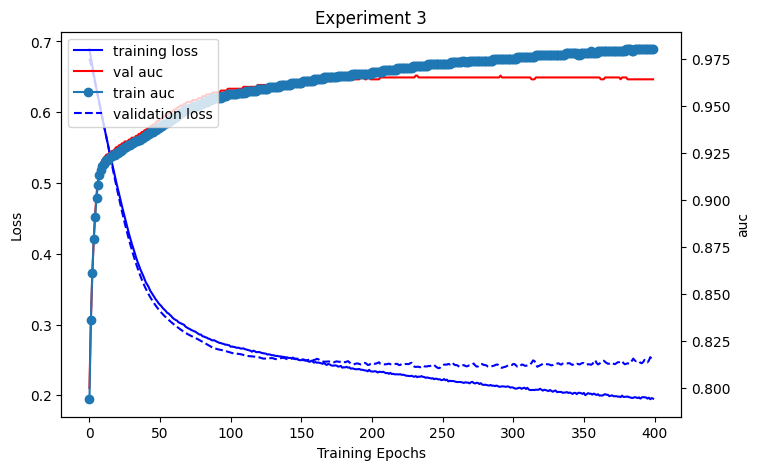

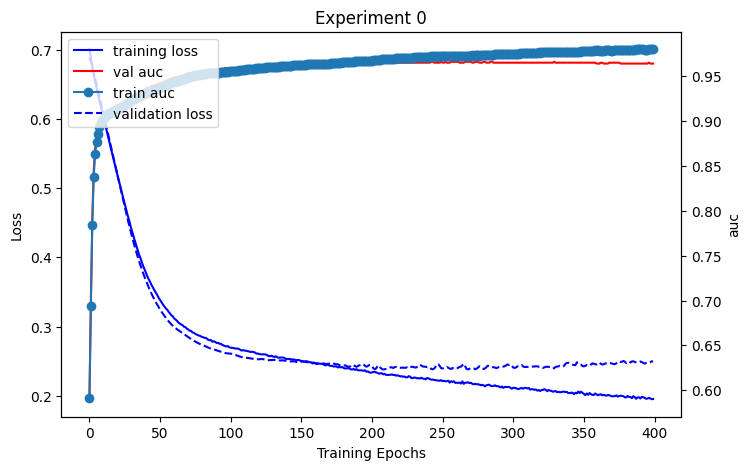

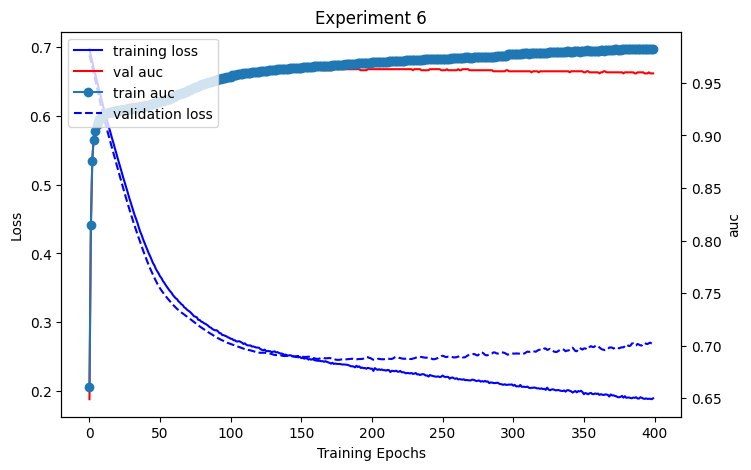

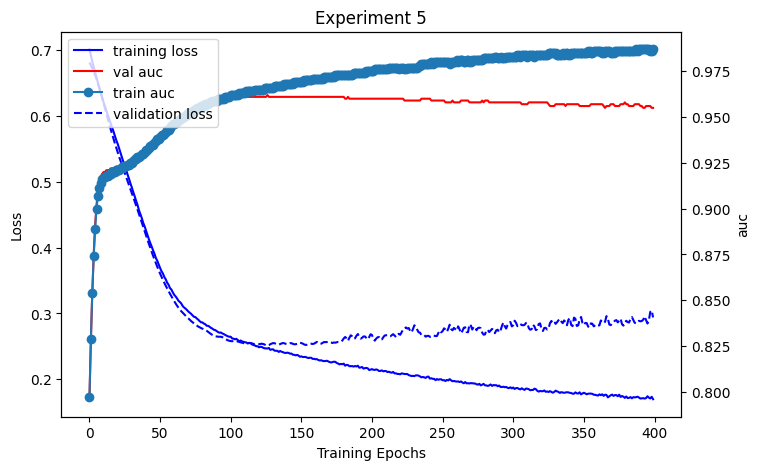

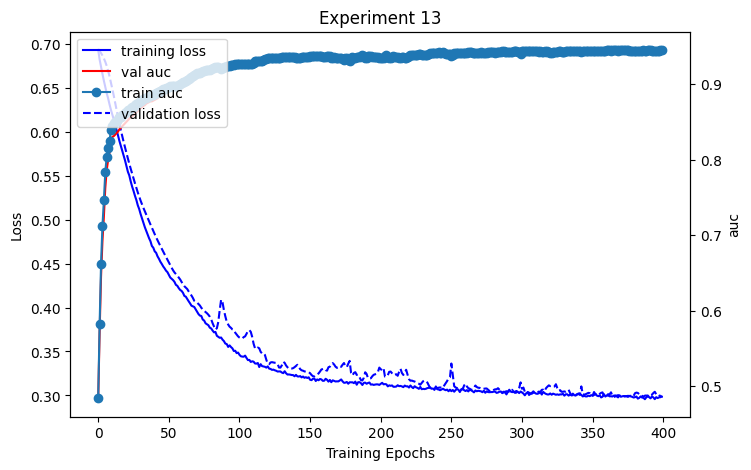

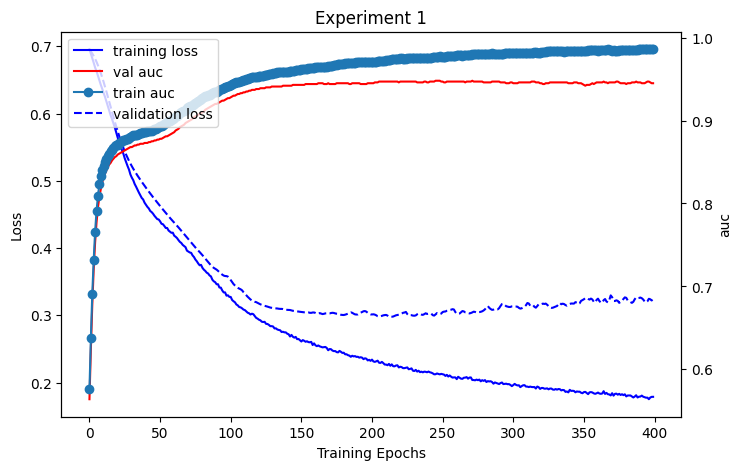

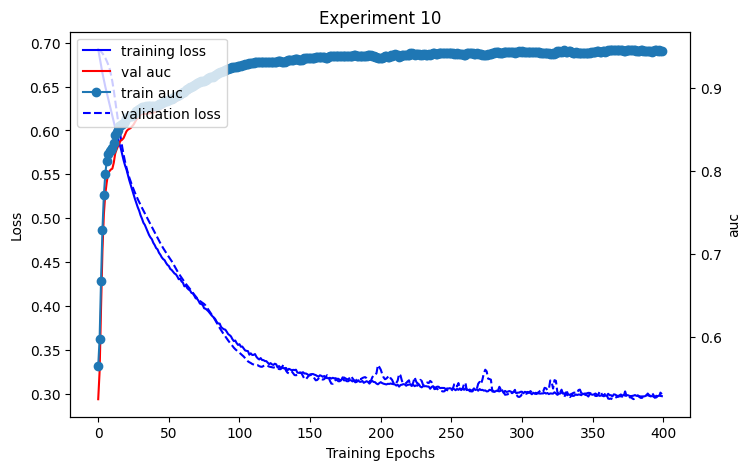

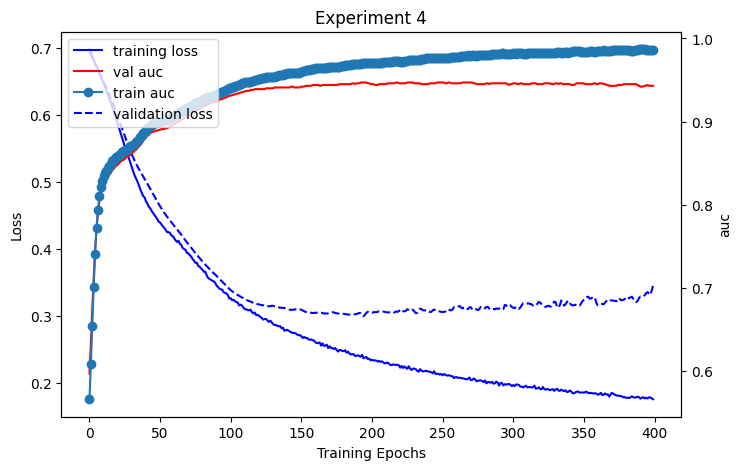

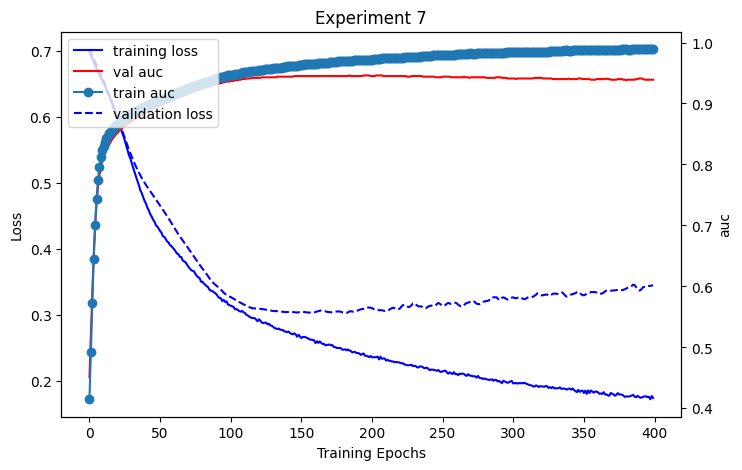

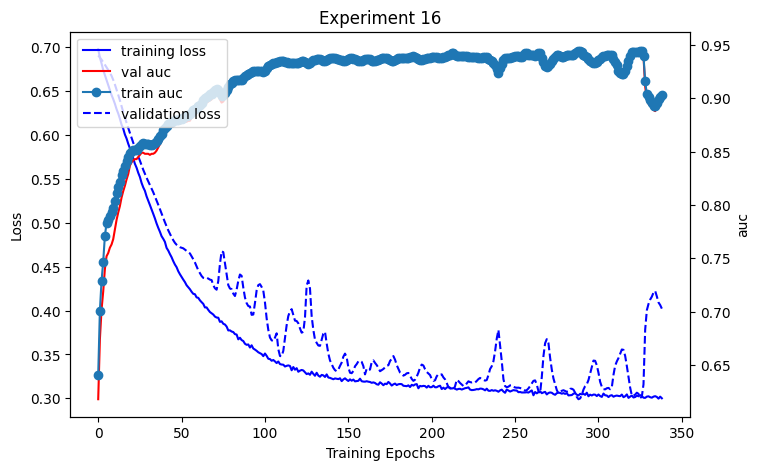

In [24]:
show_results("sage_aggr_type")

In [26]:
df.experiment_name.unique()

array(['sage_aggr_type', 'GAT_aggr_type', 'GAT_heads', 'pre_post_process'],
      dtype=object)

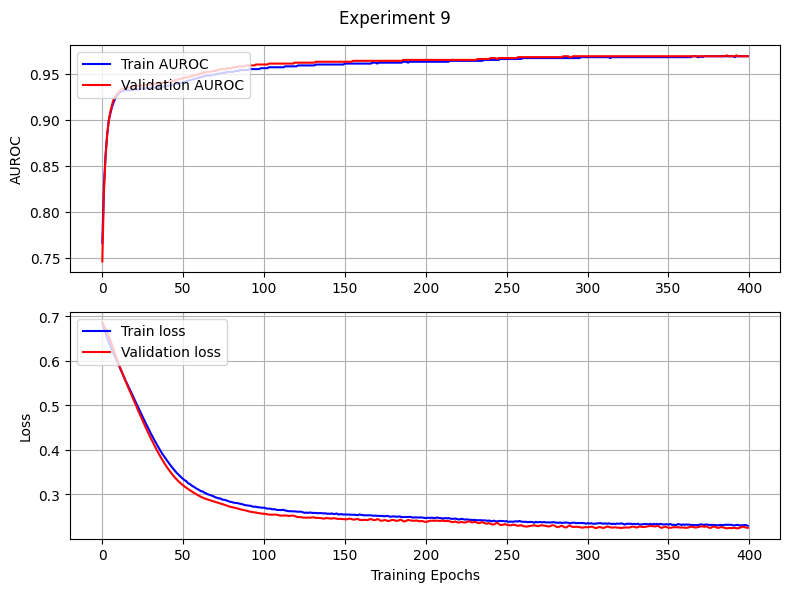

In [101]:
experiment = 9
training_utils.plot_training_stats_sep(f"Experiment {experiment}", *results_aggrs.loc[experiment,"curve_data"])

## Conv type and aggregations

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
9      True        True  SAGEConv           10         ones               32   
12     True        True  SAGEConv           10         ones               32   
15     True        True  SAGEConv           10         ones               32   
0      True        True  SAGEConv           10       random               32   
3      True        True  SAGEConv           10       random               32   
6      True        True  SAGEConv           10       random               32   
8      True        True  SAGEConv           10       random               32   
2      True        True  SAGEConv           10       random               32   
5      True        True  SAGEConv           10       random               32   
10     True        True  SAGEConv           10         ones               32   
1      True        True  SAGEConv           10       random               32   
13     True        True  SAGEConv           10         ones               32   
7      True        True  SAGEConv           10       random               32   
4      True        True  SAGEConv           10       random               32   
11     True        True  SAGEConv           10         ones               32   
17     True        True  SAGEConv           10         ones               32   
14     True        True  SAGEConv           10         ones               32   
16     True        True  SAGEConv           10         ones               32   

   layer_connectivity  jumping_knowledge macro_aggregation micro_aggregation  \
9                None              False               sum               sum   
12               None              False              mean               sum   
15               None              False               max               sum   
0                None              False               sum               sum   
3                None              False              mean               sum   
6                None              False               max               sum   
8                None              False               max               max   
2                None              False               sum               max   
5                None              False              mean               max   
10               None              False               sum              mean   
1                None              False               sum              mean   
13               None              False              mean              mean   
7                None              False               max              mean   
4                None              False              mean              mean   
11               None              False               sum               max   
17               None              False               max               max   
14               None              False              mean               max   
16               None              False               max              mean   

    msg_passing_layers  post_process_layers  pre_process_layers    auc  \
9                    2                    1                   0  0.909   
12                   2                    1                   0  0.908   
15                   2                    1                   0  0.906   
0                    2                    1                   0  0.901   
3                    2                    1                   0  0.901   
6                    2                    1                   0  0.894   
8                    2                    1                   0  0.889   
2                    2                    1                   0  0.888   
5                    2                    1                   0  0.883   
10                   2                    1                   0  0.874   
1                    2                    1                   0  0.871   
13                   2                    1                   0  0.869   


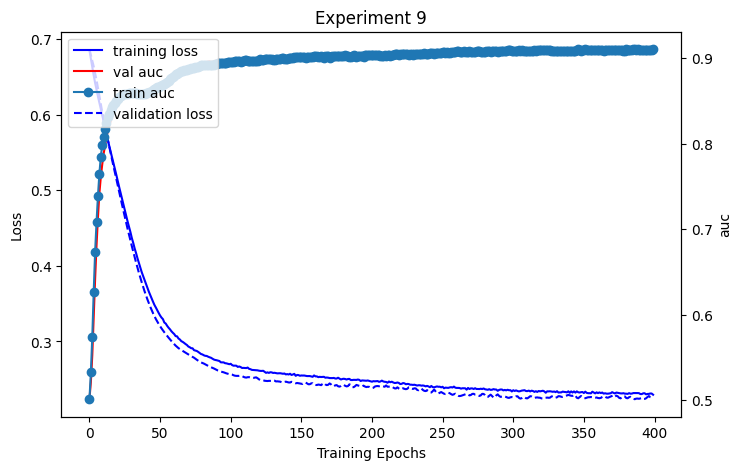

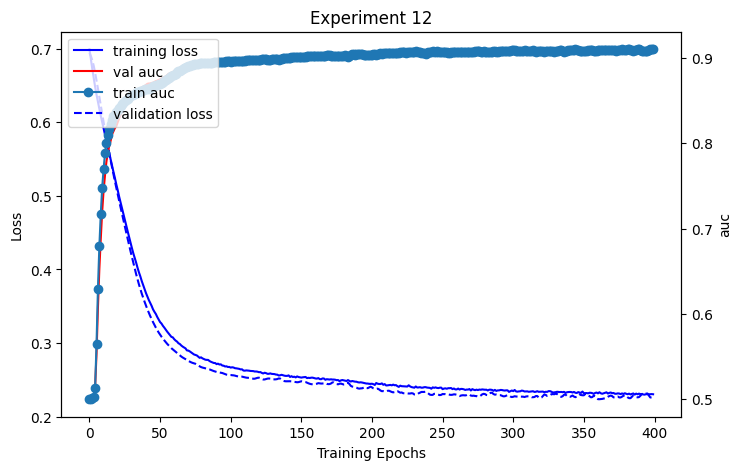

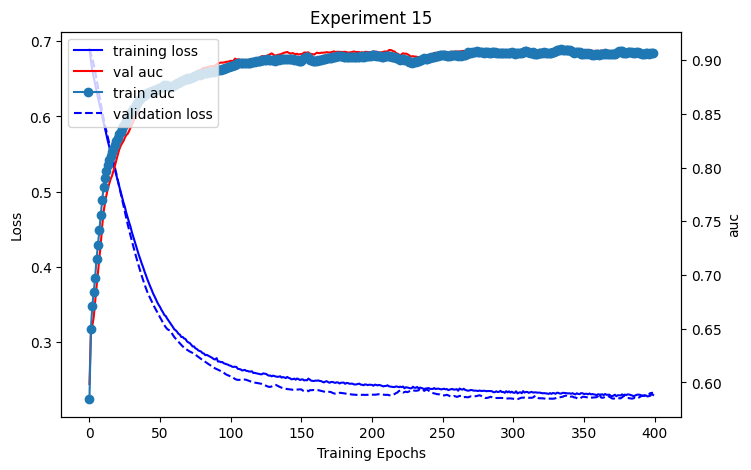

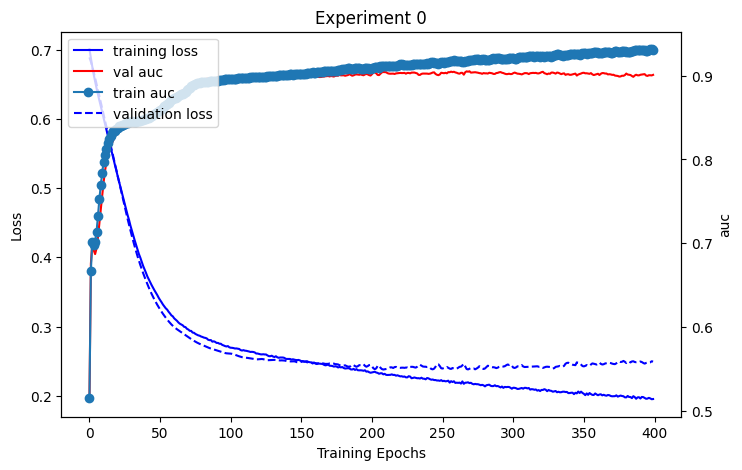

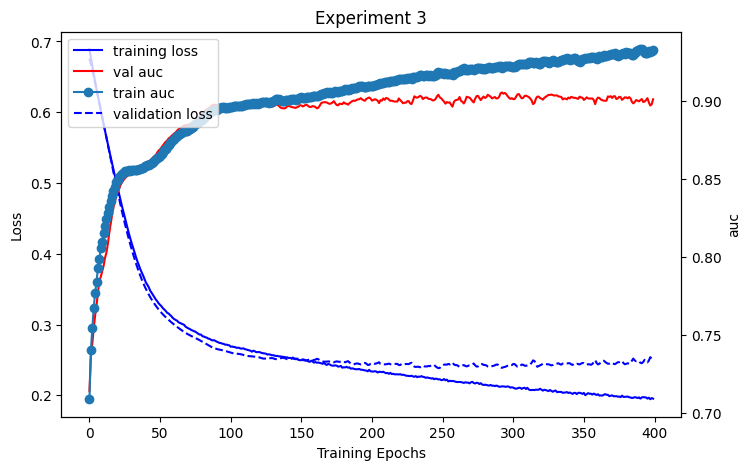

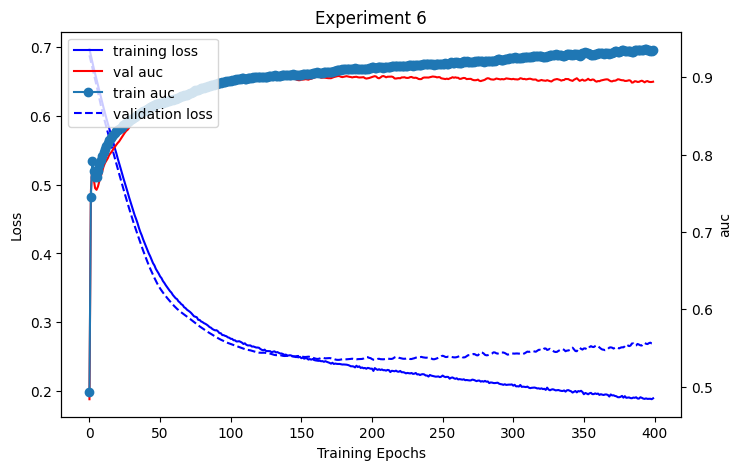

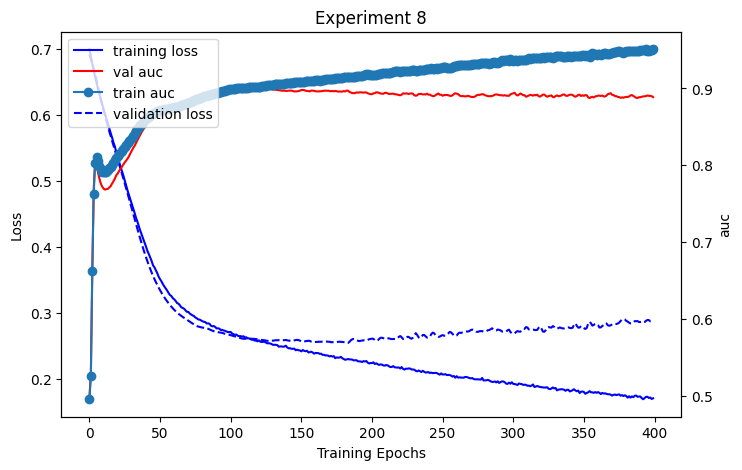

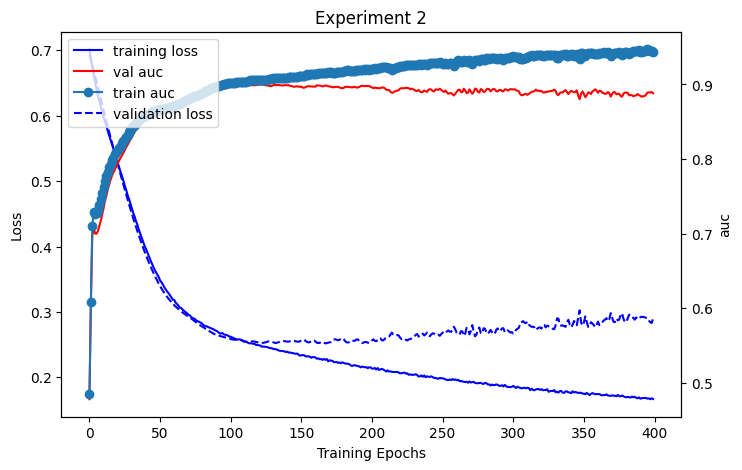

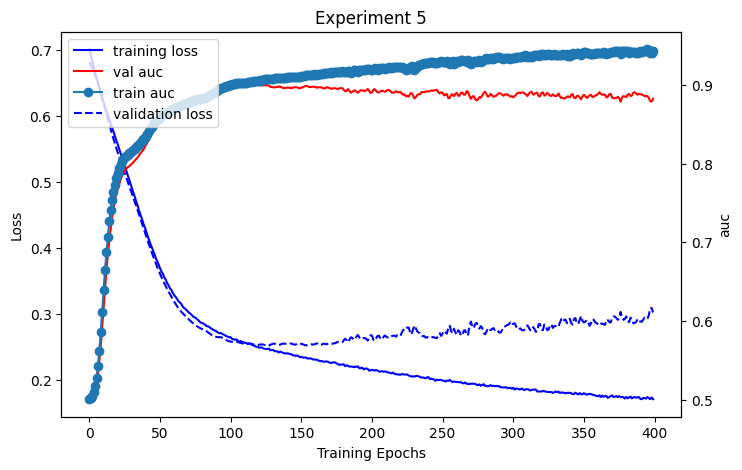

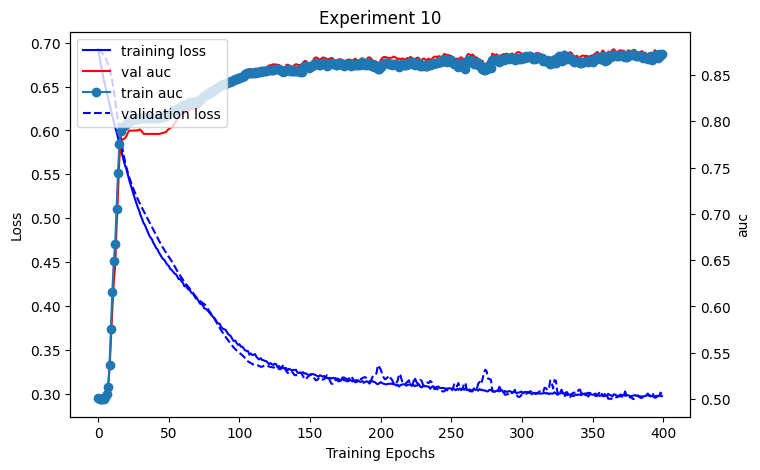

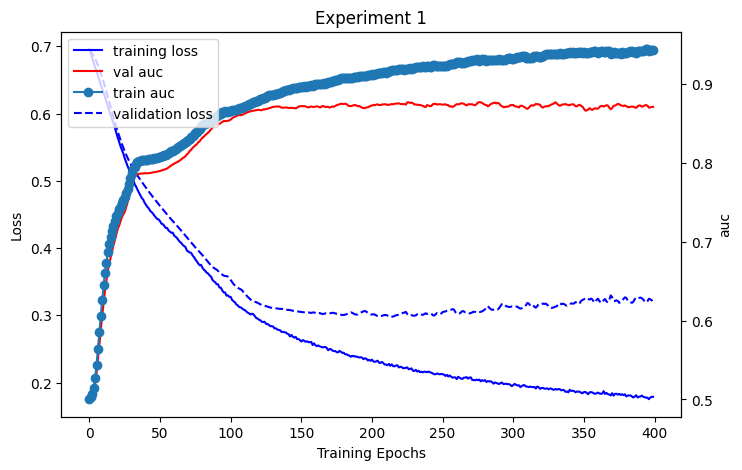

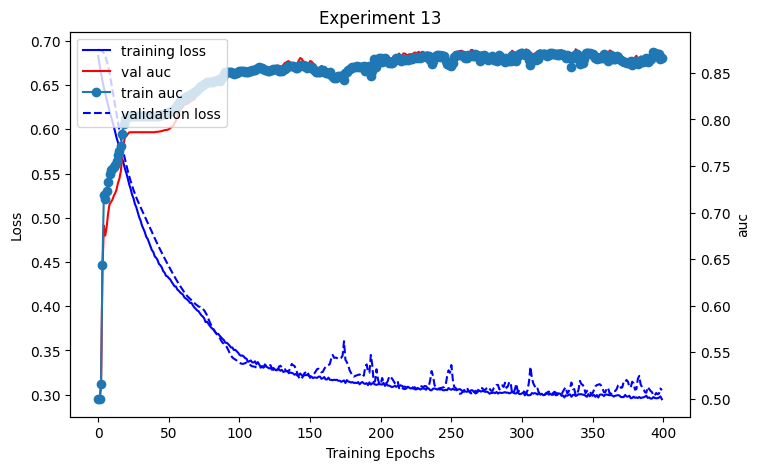

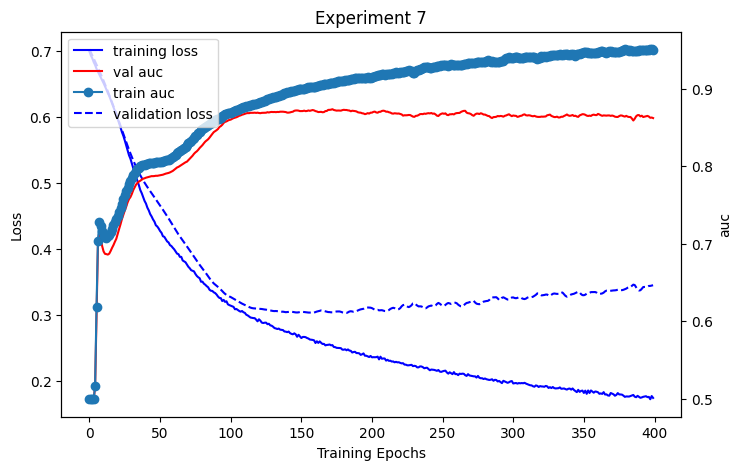

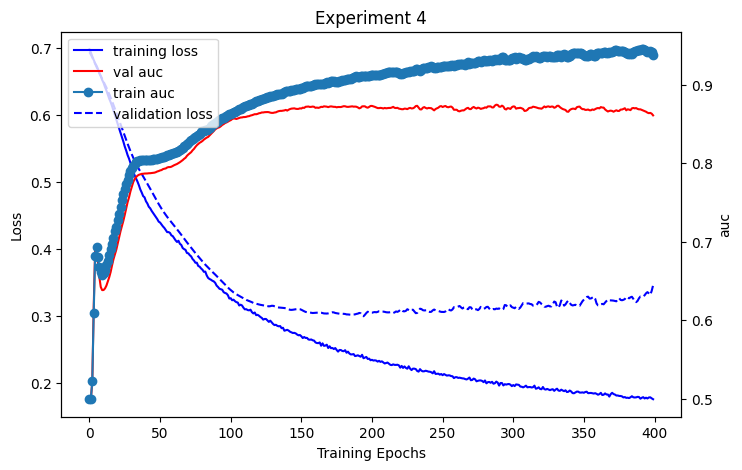

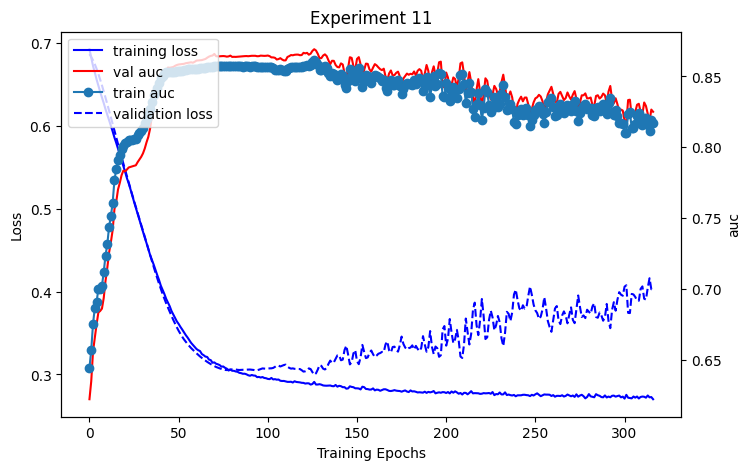

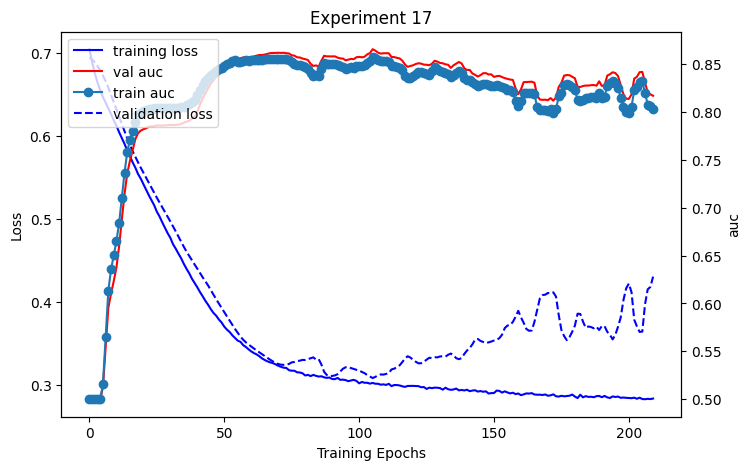

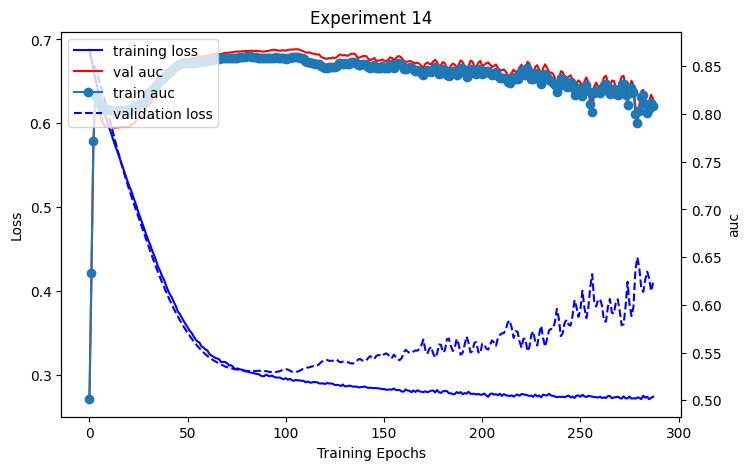

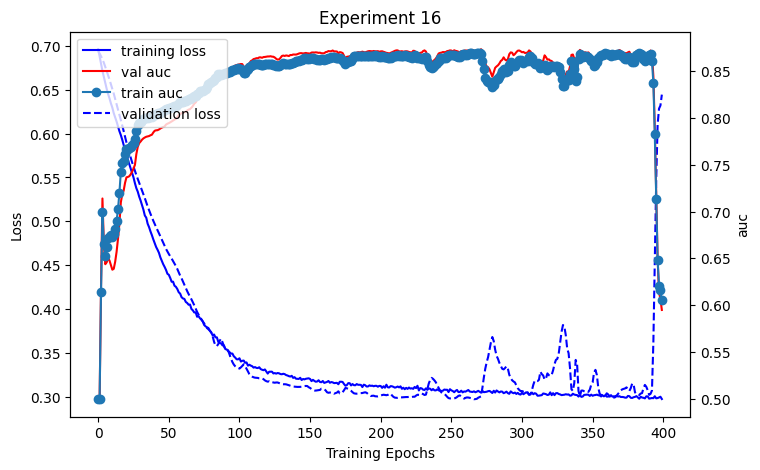

In [65]:
show_results('sage_aggr_type')

## Aggregations

L2_norm  batch_norm conv_type  delta  dropout  epochs experiment_name  \
32     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
29     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
24     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
26     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
18     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
21     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
30     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
20     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
27     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
23     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
33     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
35     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
25     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
28     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
31     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
22     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
19     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   
34     True        True   GATConv    0.1      0.1     400   GAT_aggr_type   

    feature_dim feature_type  heads  ...  micro_aggregation  \
32           10         ones      1  ...                max   
29           10         ones      1  ...                max   
24           10       random      1  ...                sum   
26           10       random      1  ...                max   
18           10       random      1  ...                sum   
21           10       random      1  ...                sum   
30           10         ones      1  ...                sum   
20           10       random      1  ...                max   
27           10         ones      1  ...                sum   
23           10       random      1  ...                max   
33           10         ones      1  ...                sum   
35           10         ones      1  ...                max   
25           10       random      1  ...               mean   
28           10         ones      1  ...               mean   
31           10         ones      1  ...               mean   
22           10       random      1  ...               mean   
19           10       random      1  ...               mean   
34           10         ones      1  ...               mean   

    msg_passing_layers normalize_output  patience post_process_layers  \
32                   2            False        10                   1   
29                   2            False        10                   1   
24                   2            False        10                   1   
26                   2            False        10                   1   
18                   2            False        10                   1   
21                   2            False        10                   1   
30                   2            False        10                   1   
20                   2            False        10                   1   
27                   2            False        10                   1   
23                   2            False        10                   1   
33                   2            False        10                   1   
35                   2            False        10                   1   
25                   2            False        10                   1   
28                   2            False        10                   1   
31                   2            False        10                   1   
22                   2            False        10                   1   
19                   2            False        10                   1   
34                   2      

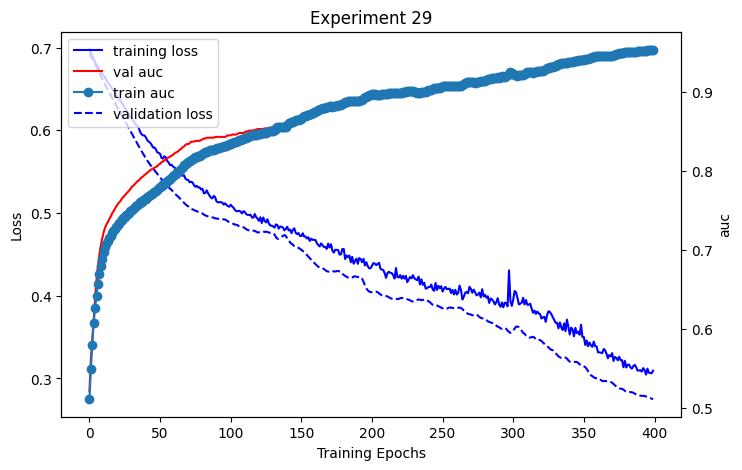

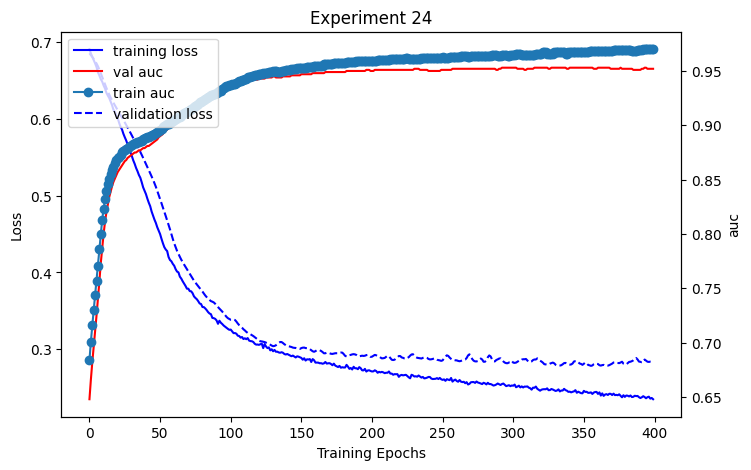

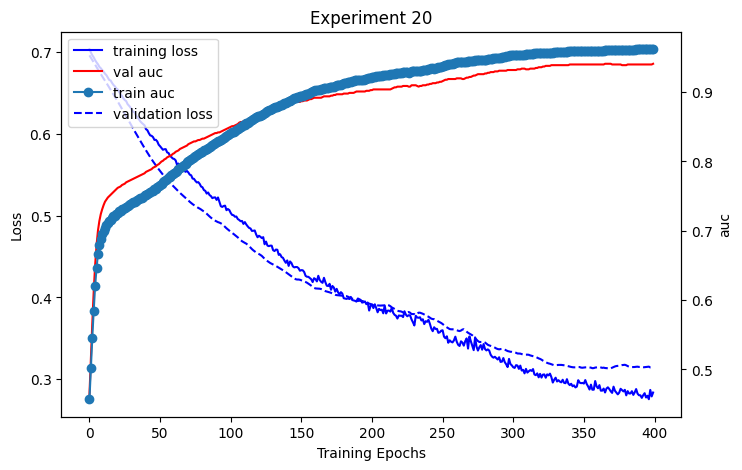

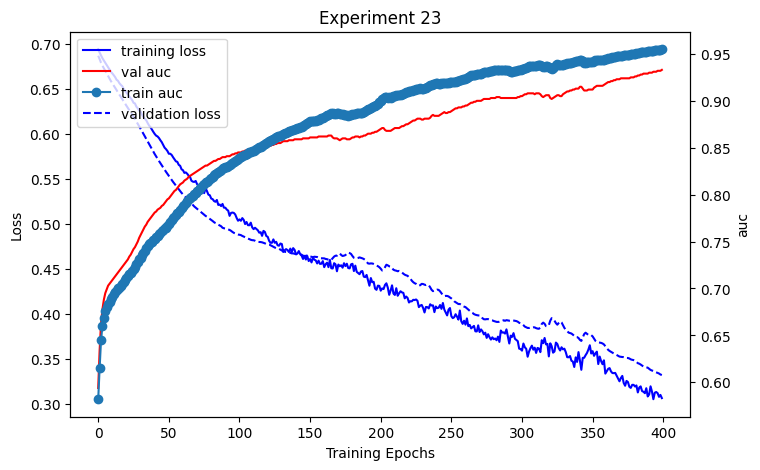

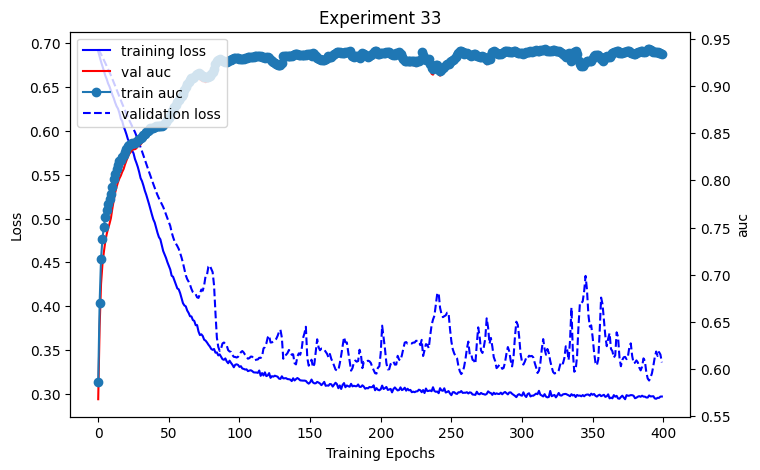

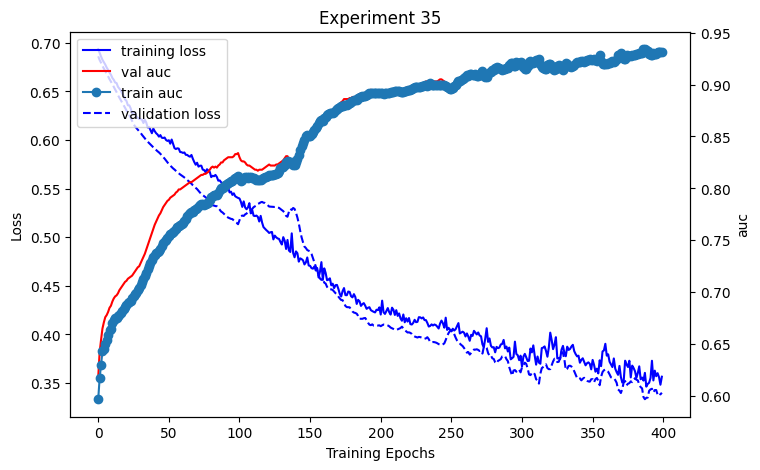

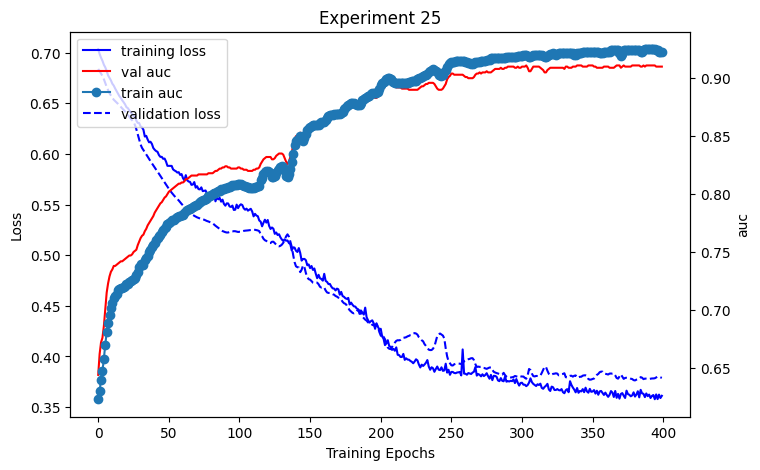

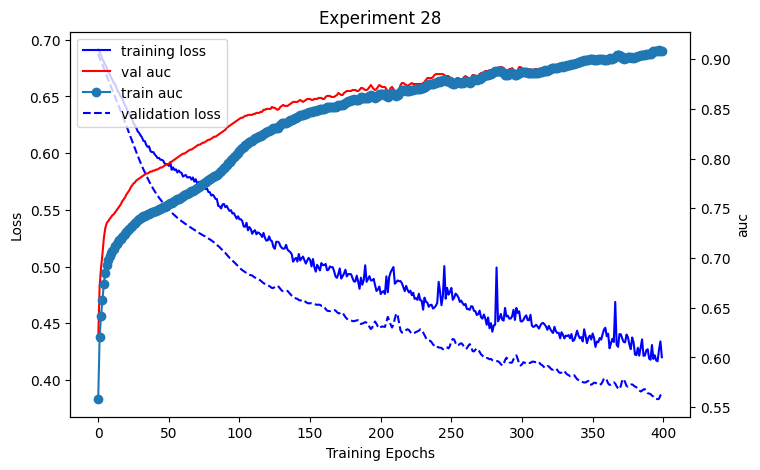

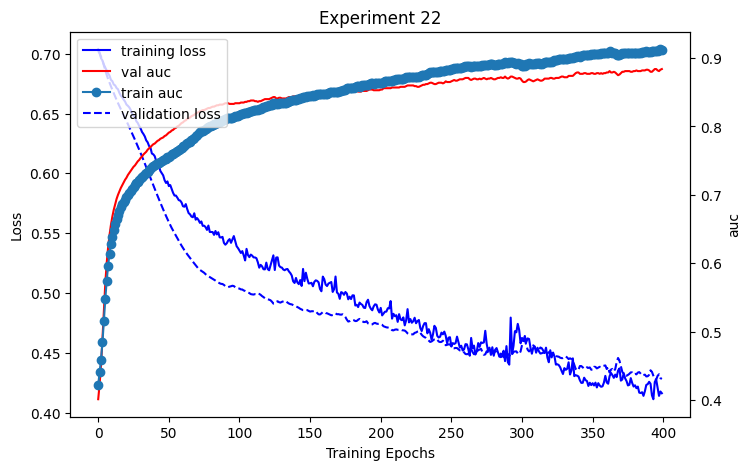

In [25]:
show_results('GAT_aggr_type')

## Connectivity

L2_norm  batch_norm conv_type  delta  dropout  epochs   experiment_name  \
3      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
6      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
17     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
14     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
13     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
16     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
12     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
11     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
10     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
15     True        True  SAGEConv    0.1      0.1     400  pre_post_process   
9      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
0      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
5      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
4      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
2      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
1      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
8      True        True  SAGEConv    0.1      0.1     400  pre_post_process   
7      True        True  SAGEConv    0.1      0.1     400  pre_post_process   

    feature_dim feature_type  heads  ...  micro_aggregation  \
3            16         ones      1  ...               mean   
6            16         ones      1  ...               mean   
17           16       random      1  ...               mean   
14           16       random      1  ...               mean   
13           16       random      1  ...               mean   
16           16       random      1  ...               mean   
12           16       random      1  ...               mean   
11           16       random      1  ...               mean   
10           16       random      1  ...               mean   
15           16       random      1  ...               mean   
9            16       random      1  ...               mean   
0            16         ones      1  ...               mean   
5            16         ones      1  ...               mean   
4            16         ones      1  ...               mean   
2            16         ones      1  ...               mean   
1            16         ones      1  ...               mean   
8            16         ones      1  ...               mean   
7            16         ones      1  ...               mean   

    msg_passing_layers normalize_output  patience post_process_layers  \
3                    2            False        10                   1   
6                    2            False        10                   2   
17                   2            False        10                   2   
14                   2            False        10                   1   
13                   2            False        10                   1   
16                   2            False        10                   2   
12                   2            False        10                   1   
11                   2            False        10                   0   
10                   2            False        10                   0   
15                   2            False        10                   2   
9                    2            False        10                   0   
0                    2            False        10                   0   
5                    2            False        10                   1   
4                    2            False        10                   1   
2                    2            False        10                   0   
1                    2            False        10                   0   
8                    2            False        10              

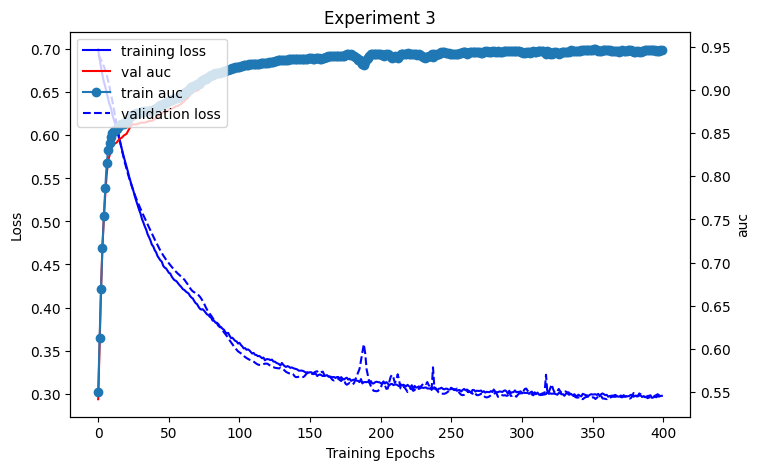

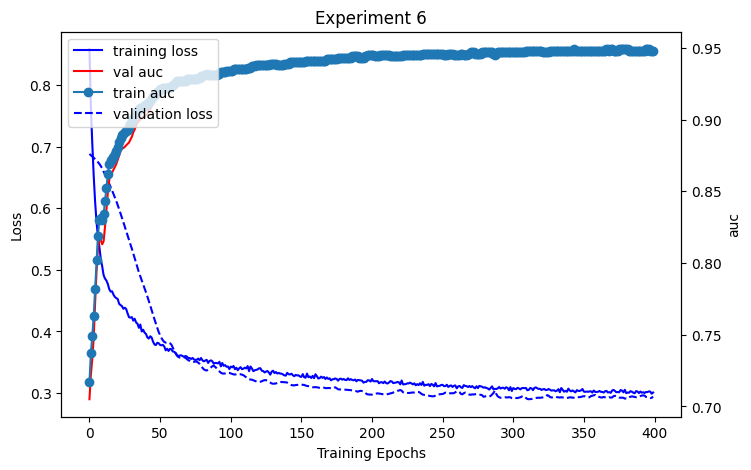

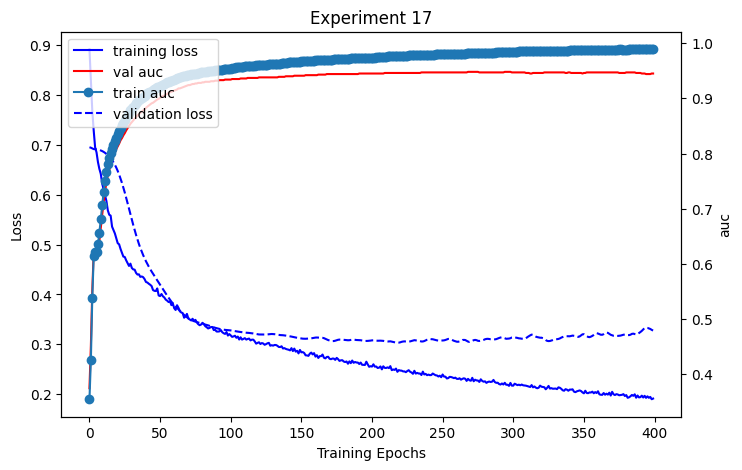

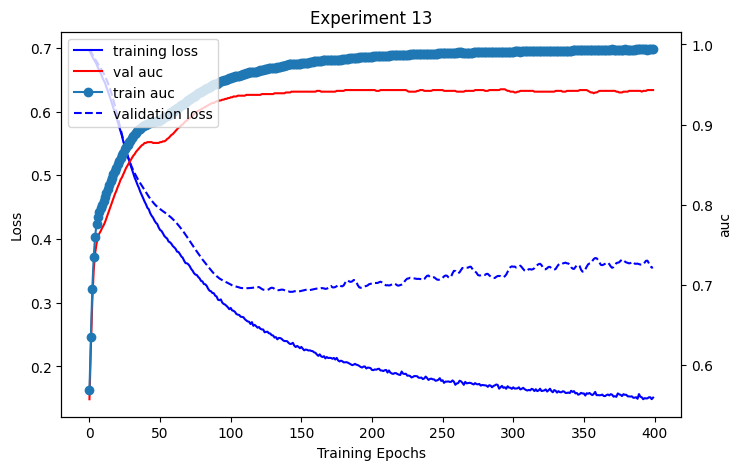

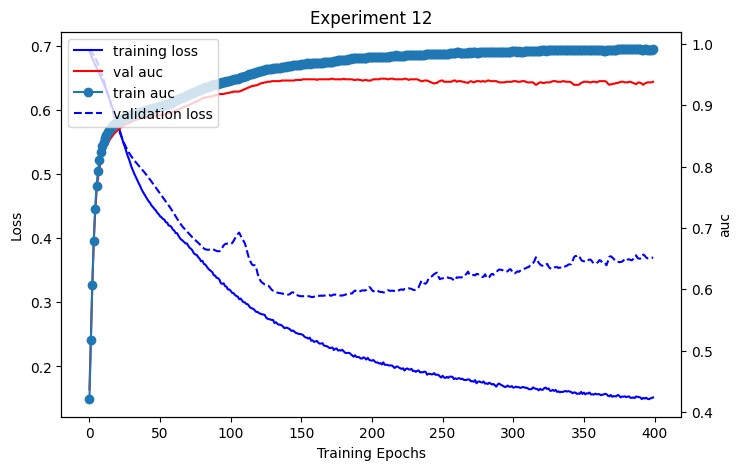

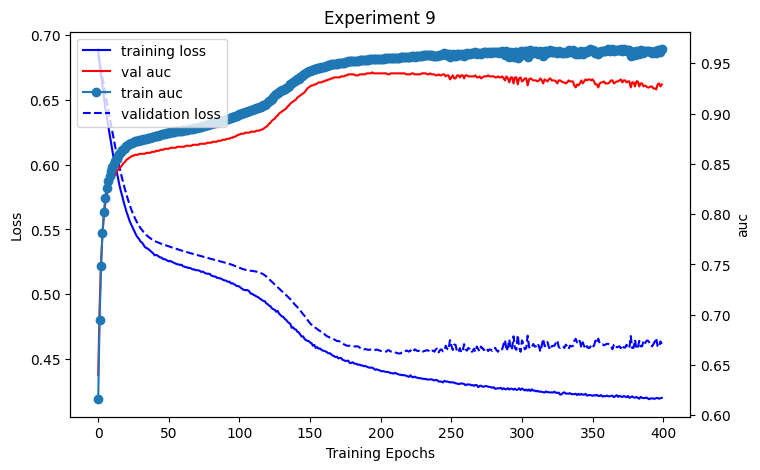

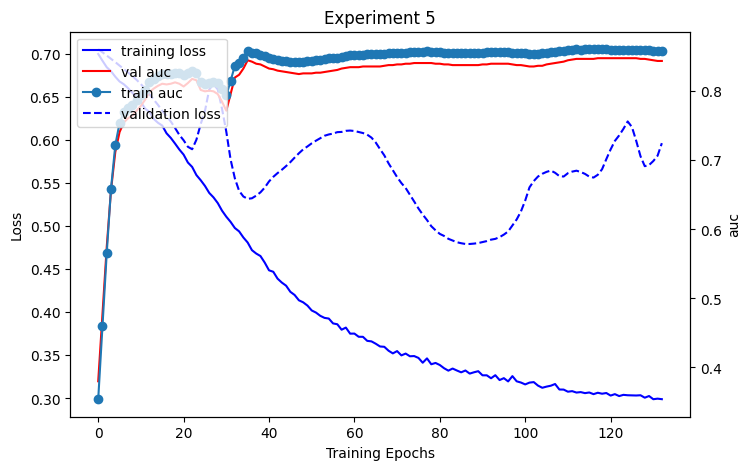

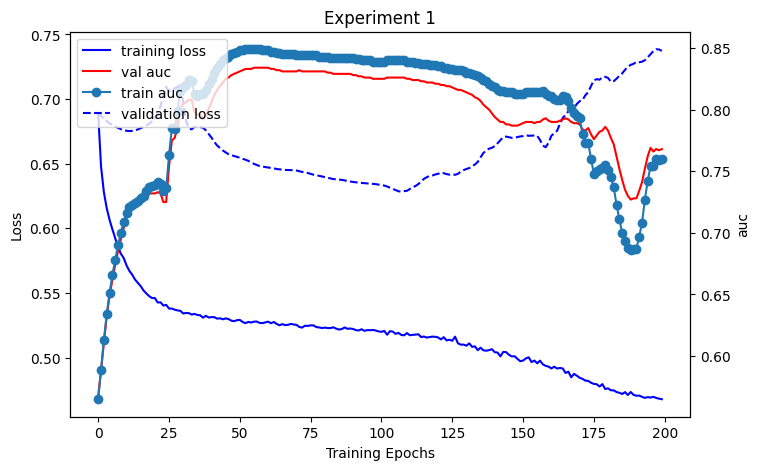

In [27]:
show_results("pre_post_process")

## L2 norm

L2_norm  batch_norm conv_type  delta  dropout  epochs experiment_name  \
47     True        True   GATConv    0.1      0.1     400       GAT_heads   
50     True        True   GATConv    0.1      0.1     400       GAT_heads   
53     True        True   GATConv    0.1      0.1     400       GAT_heads   
42     True        True   GATConv    0.1      0.1     400       GAT_heads   
36     True        True   GATConv    0.1      0.1     400       GAT_heads   
41     True        True   GATConv    0.1      0.1     400       GAT_heads   
39     True        True   GATConv    0.1      0.1     400       GAT_heads   
45     True        True   GATConv    0.1      0.1     400       GAT_heads   
44     True        True   GATConv    0.1      0.1     400       GAT_heads   
48     True        True   GATConv    0.1      0.1     400       GAT_heads   
38     True        True   GATConv    0.1      0.1     400       GAT_heads   
51     True        True   GATConv    0.1      0.1     400       GAT_heads   
46     True        True   GATConv    0.1      0.1     400       GAT_heads   
49     True        True   GATConv    0.1      0.1     400       GAT_heads   
37     True        True   GATConv    0.1      0.1     400       GAT_heads   
40     True        True   GATConv    0.1      0.1     400       GAT_heads   
43     True        True   GATConv    0.1      0.1     400       GAT_heads   
52     True        True   GATConv    0.1      0.1     400       GAT_heads   

    feature_dim feature_type  heads  ...  micro_aggregation  \
47           10         ones      2  ...                max   
50           10         ones      2  ...                max   
53           10         ones      2  ...                max   
42           10       random      2  ...                sum   
36           10       random      2  ...                sum   
41           10       random      2  ...                max   
39           10       random      2  ...                sum   
45           10         ones      2  ...                sum   
44           10       random      2  ...                max   
48           10         ones      2  ...                sum   
38           10       random      2  ...                max   
51           10         ones      2  ...                sum   
46           10         ones      2  ...               mean   
49           10         ones      2  ...               mean   
37           10       random      2  ...               mean   
40           10       random      2  ...               mean   
43           10       random      2  ...               mean   
52           10         ones      2  ...               mean   

    msg_passing_layers normalize_output  patience post_process_layers  \
47                   2            False        10                   1   
50                   2            False        10                   1   
53                   2            False        10                   1   
42                   2            False        10                   1   
36                   2            False        10                   1   
41                   2            False        10                   1   
39                   2            False        10                   1   
45                   2            False        10                   1   
44                   2            False        10                   1   
48                   2            False        10                   1   
38                   2            False        10                   1   
51                   2            False        10                   1   
46                   2            False        10                   1   
49                   2            False        10                   1   
37                   2            False        10                   1   
40                   2            False        10                   1   
43                   2            False        10                   1   
52                   2      

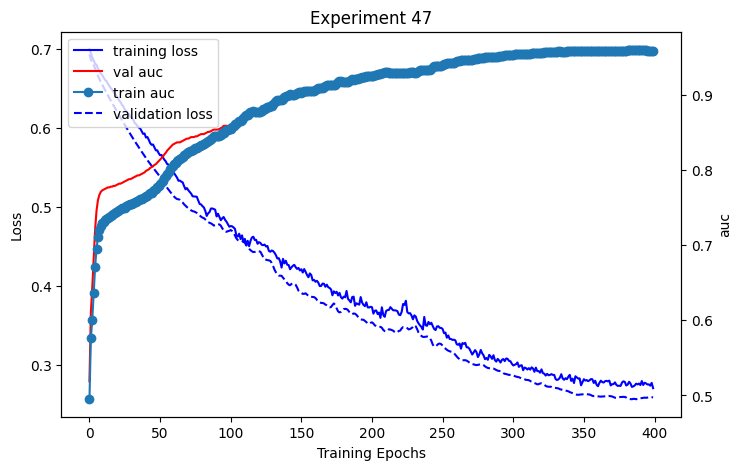

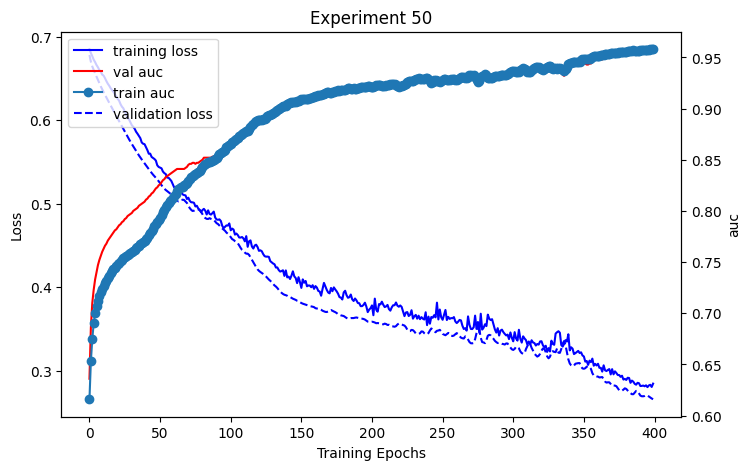

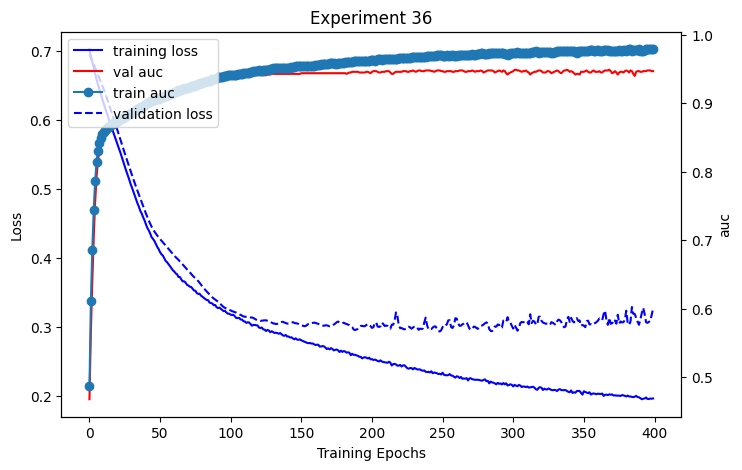

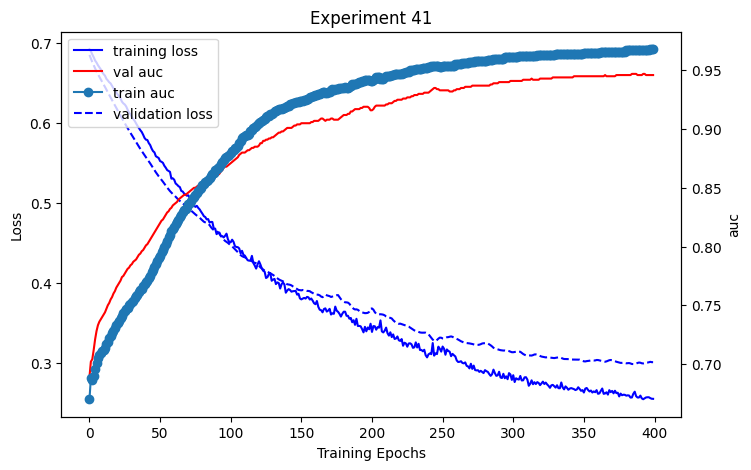

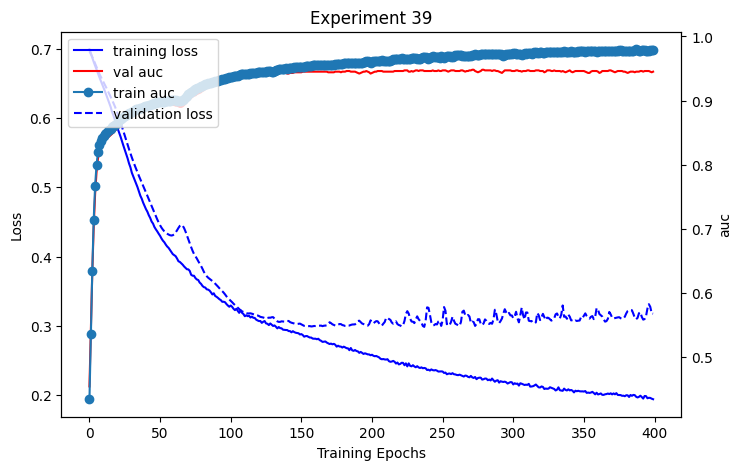

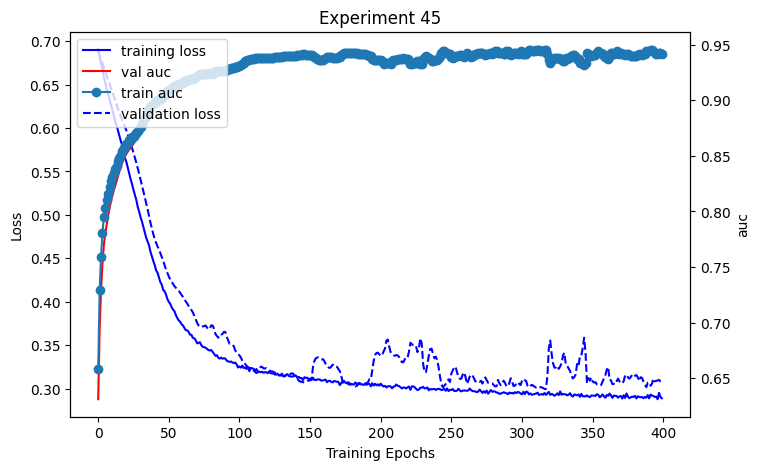

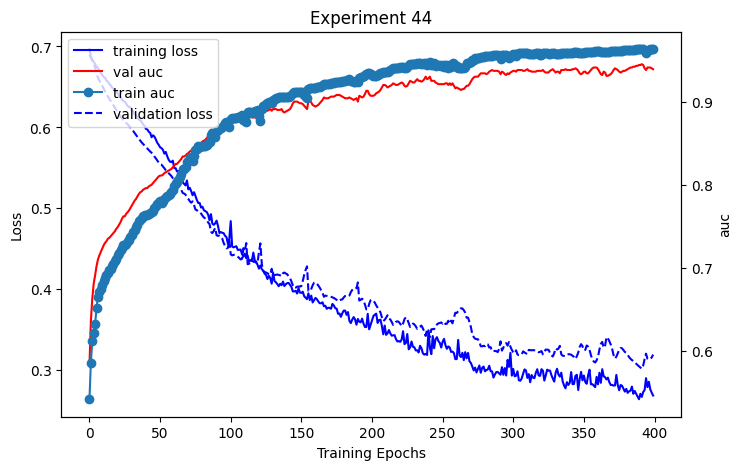

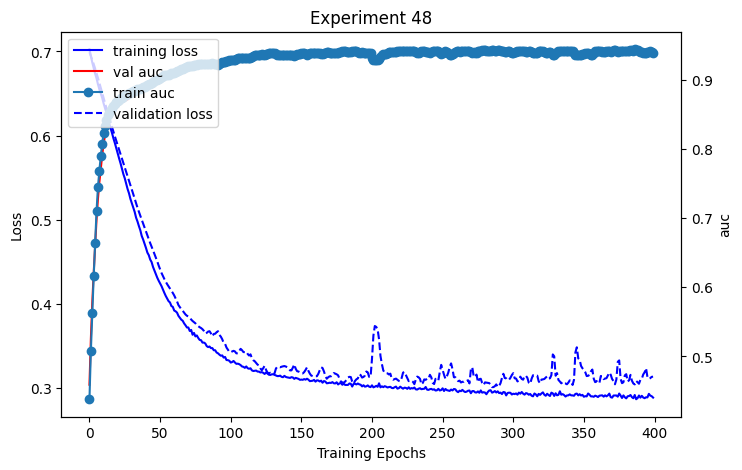

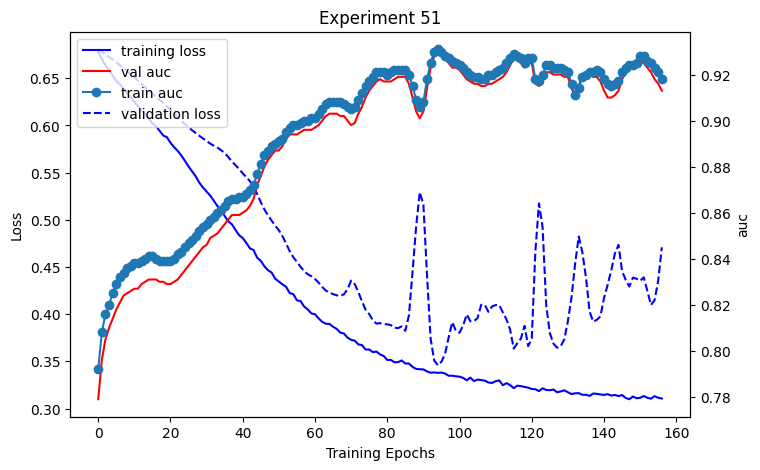

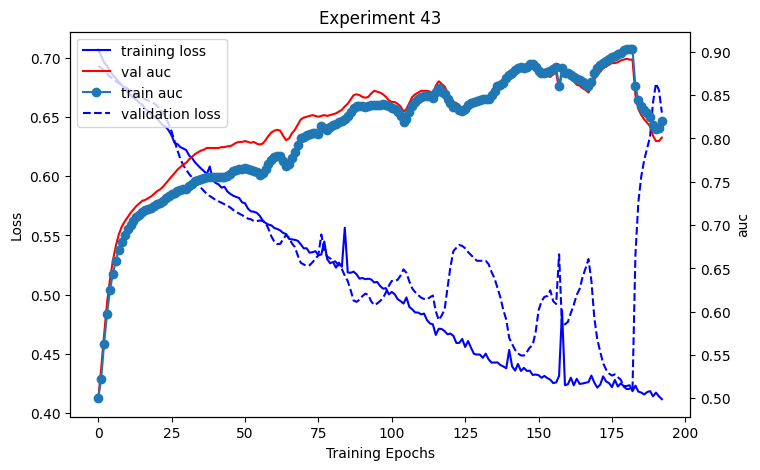

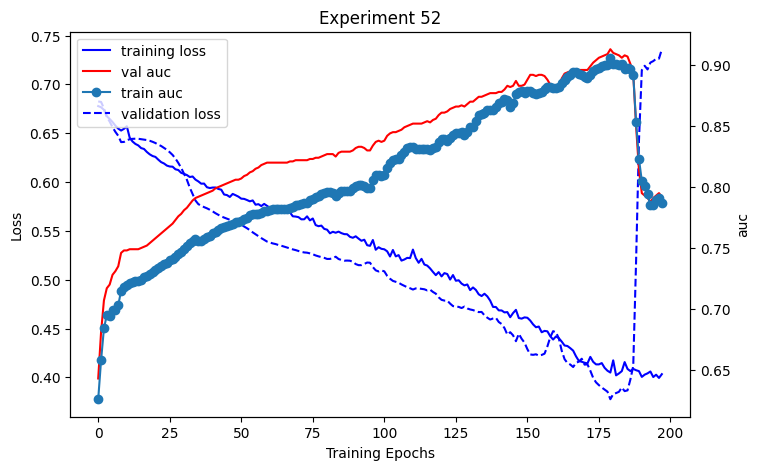

In [28]:
show_results("GAT_heads")

## Pre y post

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
48     True        True  SAGEConv           10       random               32   
50     True        True  SAGEConv           10       random               32   
47     True        True  SAGEConv           10       random               32   
65     True        True  SAGEConv           10       random               32   
59     True        True  SAGEConv           10       random               32   
60     True        True  SAGEConv           10       random               32   
71     True        True  SAGEConv           10       random               32   
68     True        True  SAGEConv           10       random               32   
66     True        True  SAGEConv           10       random               32   
56     True        True  SAGEConv           10       random               32   
57     True        True  SAGEConv           10       random               32   
62     True        True  SAGEConv           10       random               32   
63     True        True  SAGEConv           10       random               32   
54     True        True  SAGEConv           10       random               32   
53     True        True  SAGEConv           10       random               32   
58     True        True  SAGEConv           10       random               32   
67     True        True  SAGEConv           10       random               32   
70     True        True  SAGEConv           10       random               32   
61     True        True  SAGEConv           10       random               32   
45     True        True  SAGEConv           10       random               32   
49     True        True  SAGEConv           10       random               32   
51     True        True  SAGEConv           10       random               32   
52     True        True  SAGEConv           10       random               32   
69     True        True  SAGEConv           10       random               32   
55     True        True  SAGEConv           10       random               32   
46     True        True  SAGEConv           10       random               32   
64     True        True  SAGEConv           10       random               32   

   layer_connectivity macro_aggregation micro_aggregation  msg_passing_layers  \
48               None              mean              mean                   1   
50               None              mean              mean                   1   
47               None              mean              mean                   1   
65               None              mean              mean                   3   
59               None              mean              mean                   2   
60               None              mean              mean                   2   
71               None              mean              mean                   2   
68               None              mean              mean                   3   
66               None              mean              mean                   3   
56               None              mean              mean                   2   
57               None              mean              mean                   2   
62               None              mean              mean                   3   
63               None              mean              mean                   3   
54               None              mean              mean                   2   
53               None              mean              mean                   2   
58               None              mean              mean                   2   
67               None              mean              mean                   3   
70               None              mean              mean                   3   
61               None              mean              mean                   2   
45               None              mean              mean                   1   
49               None              mean              mean     

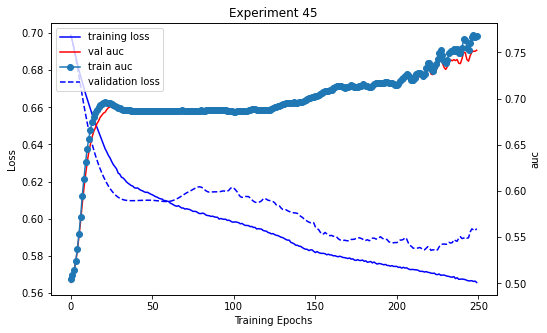

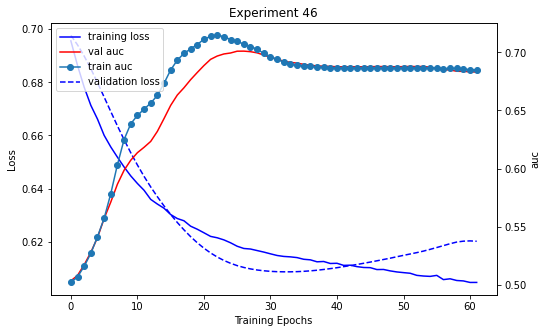

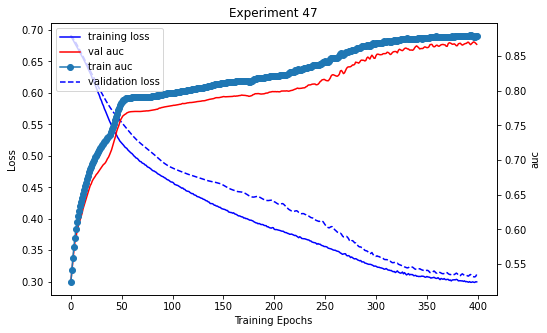

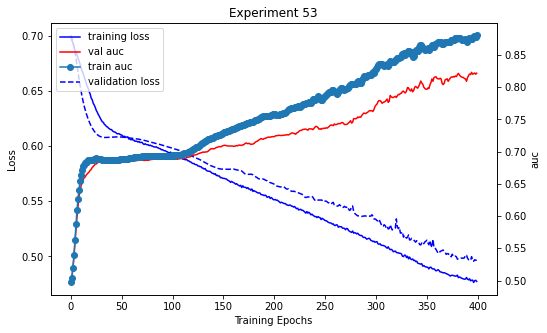

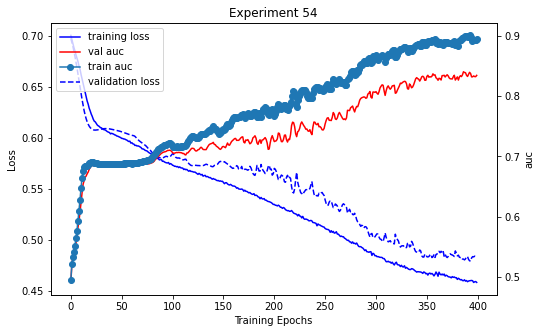

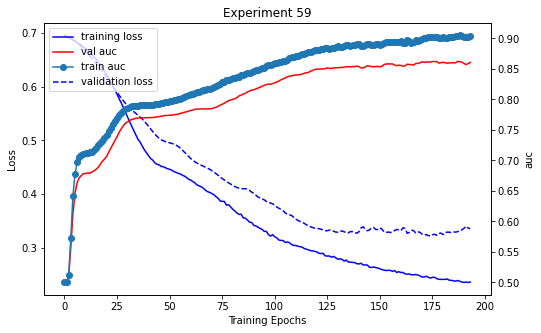

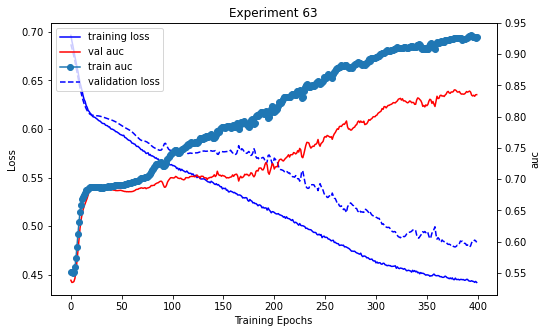

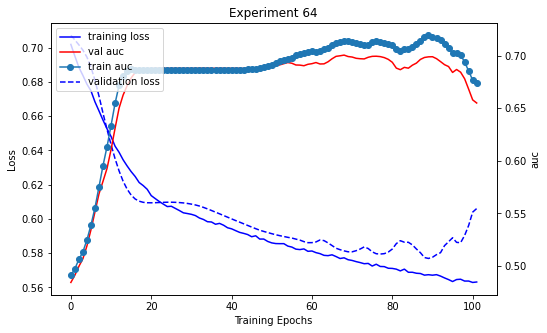

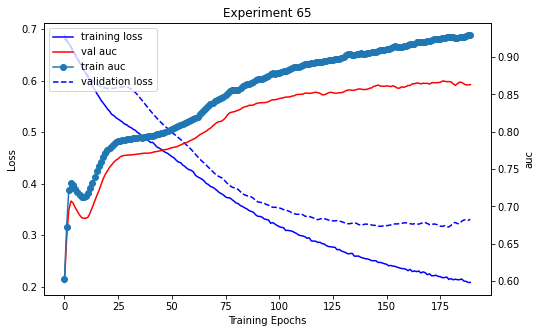

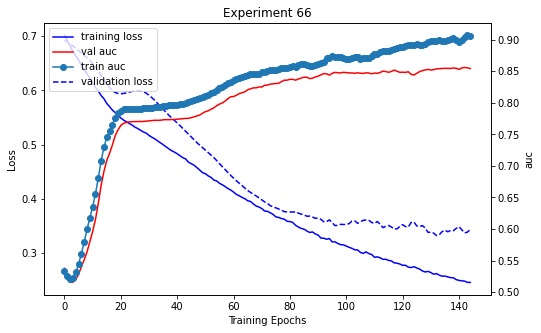

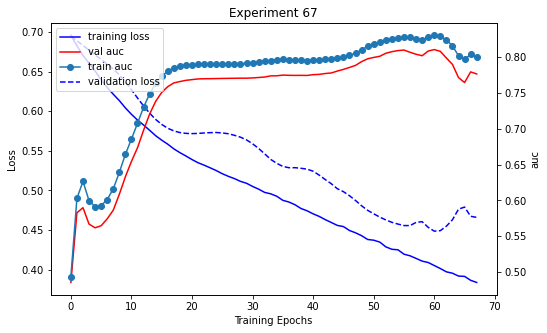

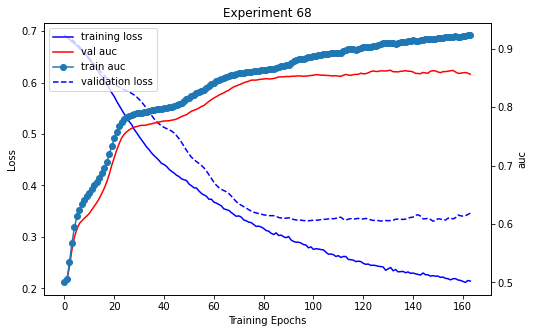

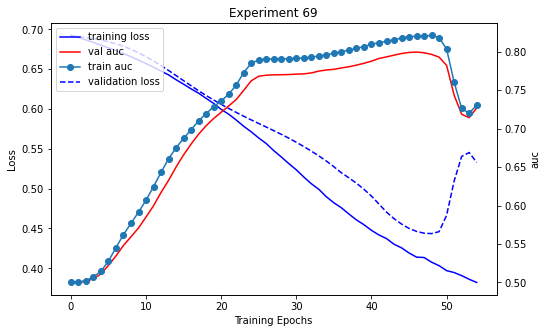

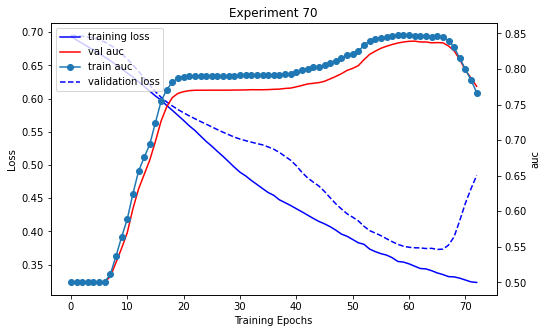

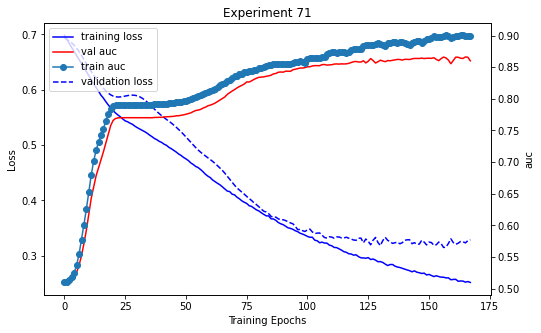

In [149]:
show_results('num_layers')

## Message passing

In [151]:
experiment_index.keys()

dict_keys(['hidden_dim', 'aggregations_conv_type', 'aggregations_feature_type', 'connectivity', 'L2_norm', 'num_layers', 'feature_dim'])

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
72     True        True  SAGEConv           10         ones               32   
74     True        True  SAGEConv           50         ones               32   
76     True        True  SAGEConv          100         ones               32   
73     True        True  SAGEConv           50       random               32   
75     True        True  SAGEConv          100       random               32   

   layer_connectivity macro_aggregation micro_aggregation  msg_passing_layers  \
72               None              mean              mean                   2   
74               None              mean              mean                   2   
76               None              mean              mean                   2   
73               None              mean              mean                   2   
75               None              mean              mean                   2   

    post_process_layers  pre_process_layers    auc  
72                    1                   1  0.802  
74                    1                   1  0.800  
76                    1                   1  0.797  
73                    1                   1  0.794  
75                    1                   1  0.742

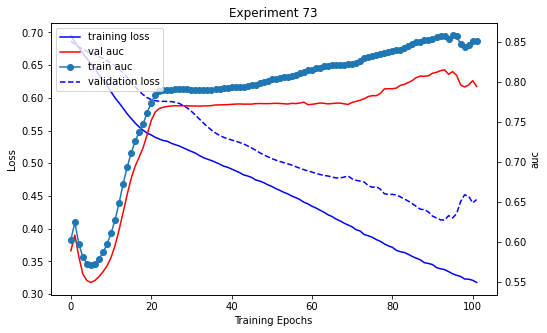

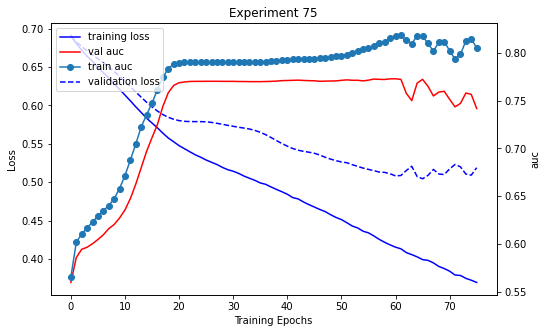

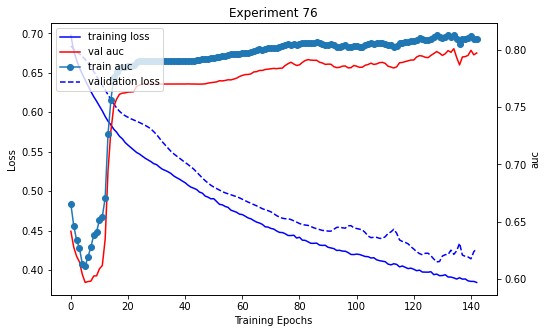

In [167]:
show_results("feature_dim")

## Feature type

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
34     True        True  SAGEConv           50         ones               32   
36     True        True  SAGEConv          100         ones               32   
32     True        True  SAGEConv           10         ones               32   
35     True        True  SAGEConv          100       random               32   
33     True        True  SAGEConv           50       random               32   
31     True        True  SAGEConv           10       random               32   

   layer_connectivity macro_aggregation micro_aggregation  msg_passing_layers  \
34               None              mean               sum                   2   
36               None              mean               sum                   2   
32               None              mean               sum                   2   
35               None              mean               sum                   2   
33               None              mean               sum                   2   
31               None              mean               sum                   2   

    post_process_layers  pre_process_layers    auc  
34                    1                   1  0.906  
36                    1                   1  0.904  
32                    1                   1  0.899  
35                    1                   1  0.887  
33                    1                   1  0.886  
31                    1                   1  0.882

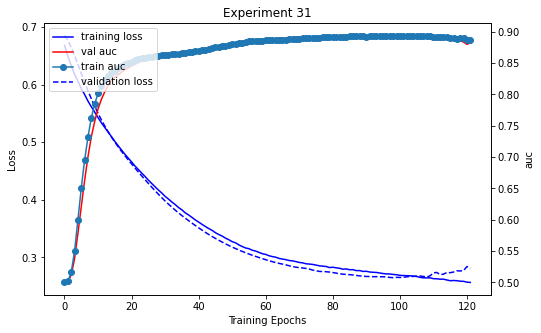

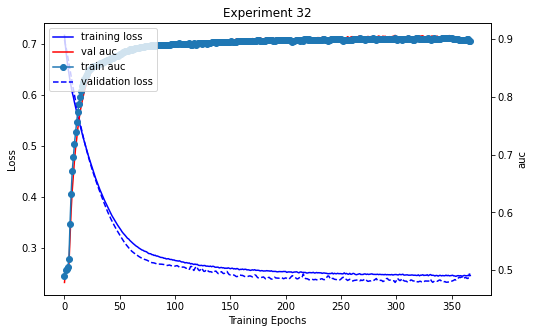

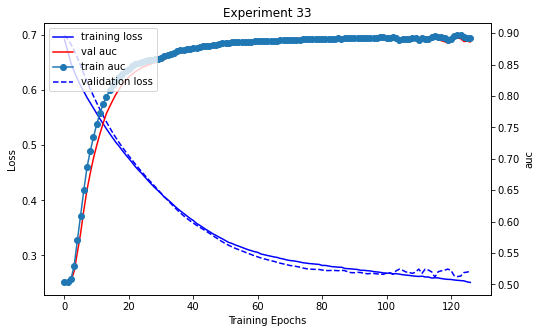

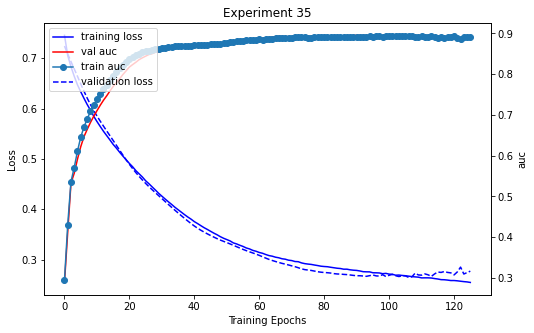

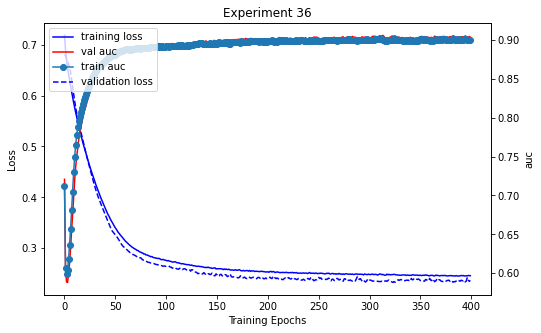

In [66]:
show_results("feature_type")

# Top 5 y worst 5

In [202]:
worst_5 = df.sort_values(by="auc")[:5].round(2)
display(worst_5)

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
64     True        True  SAGEConv           10       random               32   
46     True        True  SAGEConv           10       random               32   
55     True        True  SAGEConv           10       random               32   
2      True        True  SAGEConv           10       random              128   
69     True        True  SAGEConv           10       random               32   

   layer_connectivity macro_aggregation micro_aggregation  msg_passing_layers  \
64               None              mean              mean                   3   
46               None              mean              mean                   1   
55               None              mean              mean                   2   
2                None              mean              mean                   2   
69               None              mean              mean                   3   

    post_process_layers  pre_process_layers   auc  
64                    0                   2  0.65  
46                    0                   2  0.68  
55                    0                   2  0.71  
2                     1                   1  0.72  
69                    2                   1  0.73

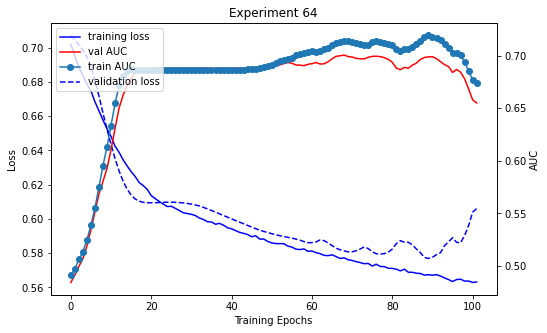

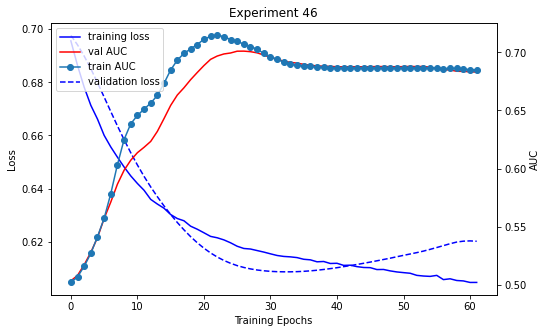

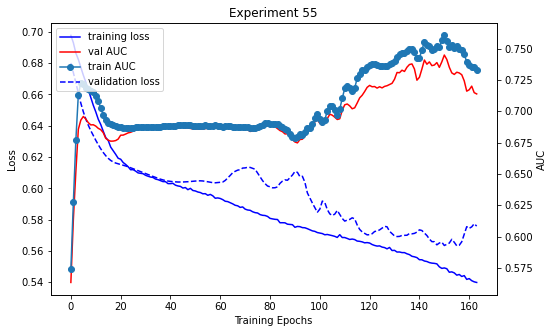

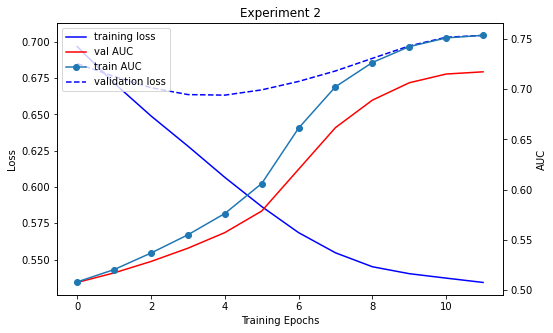

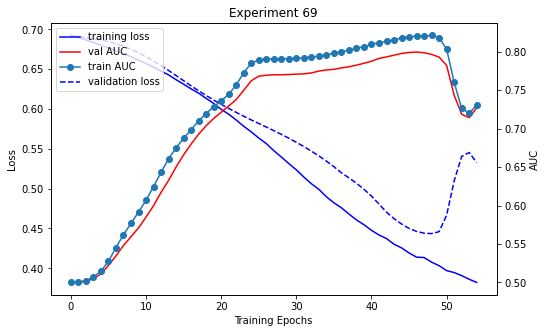

In [180]:
for experiment in worst_5.index.values:
    plot_training_stats(f"Experiment {experiment}",*results.loc[experiment,"curve_data"],"AUC")

In [206]:
top_5 = df.sort_values(by="auc", ascending=False)[:5].round(2)
display(top_5)

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
34     True        True  SAGEConv           10         ones               32   
31     True        True  SAGEConv           10         ones               32   
37     True        True  SAGEConv           10         ones               32   
10     True        True  SAGEConv           10       random               32   
7      True        True  SAGEConv           10       random               32   

   layer_connectivity macro_aggregation micro_aggregation  msg_passing_layers  \
34               None               sum               sum                   2   
31               None              mean               sum                   2   
37               None               max               sum                   2   
10               None               max               sum                   2   
7                None               sum               sum                   2   

    post_process_layers  pre_process_layers   auc  
34                    1                   1  0.91  
31                    1                   1  0.90  
37                    1                   1  0.90  
10                    1                   1  0.89  
7                     1                   1  0.89

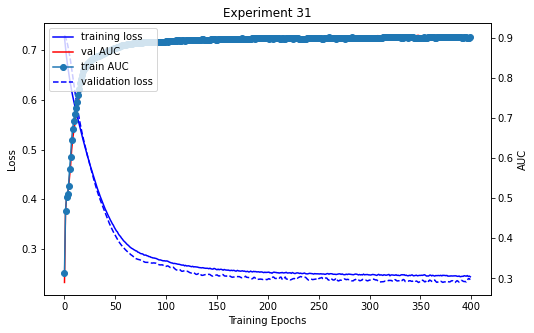

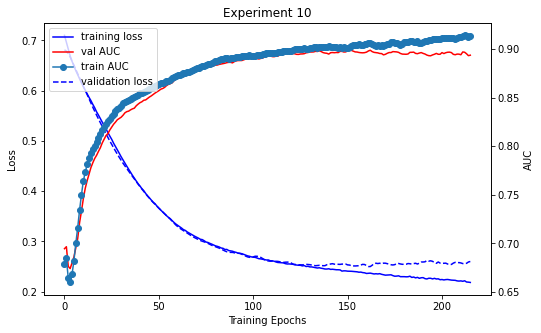

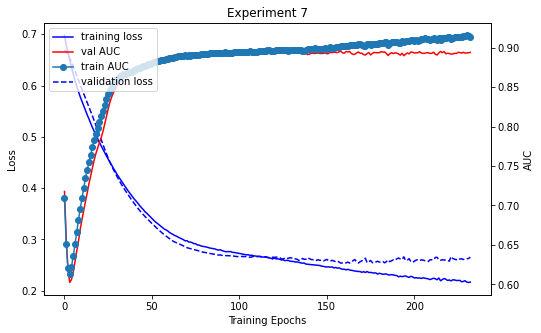

In [182]:
for experiment in top_5.index.values:
    plot_training_stats(f"Experiment {experiment}",*results.loc[experiment,"curve_data"],"AUC")

In [187]:
df[(df.msg_passing_layers == 2)&(df.pre_process_layers == 0)&(df.post_process_layers == 0)]

L2_norm  batch_norm conv_type  feature_dim feature_type  hidden_channels  \
53     True        True  SAGEConv           10       random               32   

   layer_connectivity macro_aggregation micro_aggregation  msg_passing_layers  \
53               None              mean              mean                   2   

    post_process_layers  pre_process_layers       auc  
53                    0                   0  0.821509

In [188]:
plot_training_stats("SAGE prototype",*results.loc[53,"curve_data"],"AUC")